In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

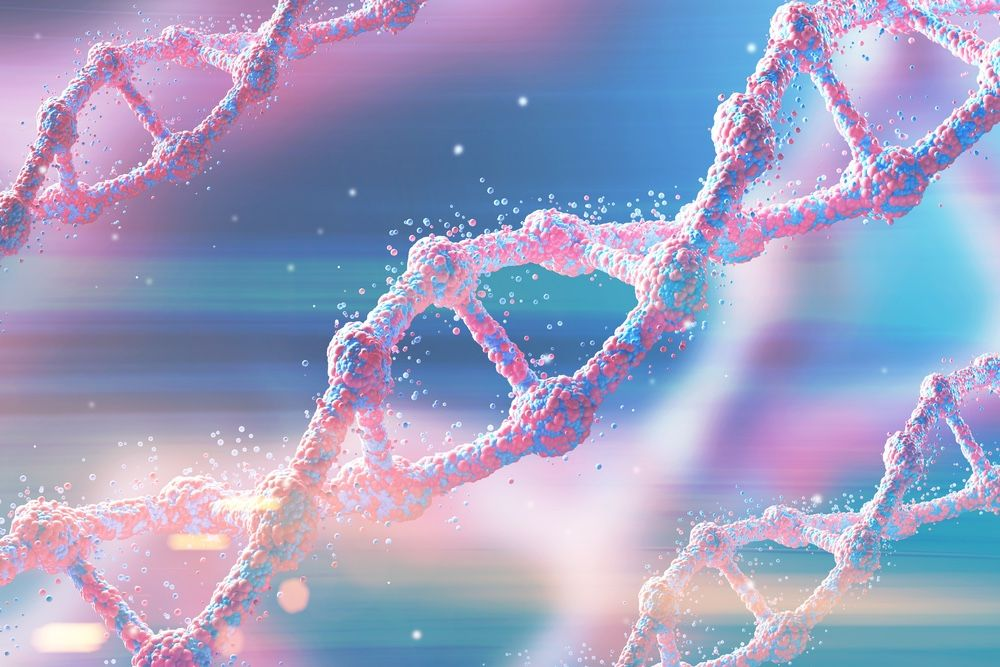

In [2]:
from IPython.display import Image

Image("/kaggle/input/graph-age-images/DNA starting image.jpg")

# Welcome Researcher to GraphAge 
#### turn on GPU if not done

# YOU HAVE TO CHOOSE THESE RESEARCHER for your purpose

In [3]:
I_want_to_train=False
I_want_to_change_features=False
I_want_to_see_the_best=True
I_want_to_train_altumage=False
I_want_to_see_altumAge_best=True


# welcome Riddle
#### What walks on 4 legs in the morning and 2 legs in the afternoon and on 3 in the evening
### **Ans** *Humans*!!
#### Because Human aging is set to be a universal truth but as humans ***we do not accept it***
####  So this is our war against aging

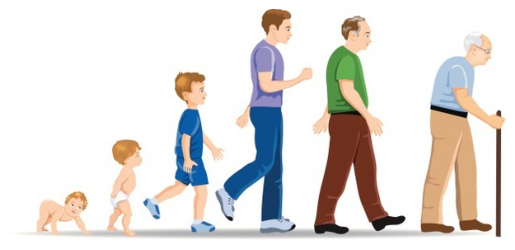

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread("/kaggle/input/graph-age-images/getting old (2).jfif")
imgplot = plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()


In [5]:
!pwd

/kaggle/working


In [6]:
!ls /kaggle/input

all-organs4			   checkpoint-new  graph-age-images
blood-explanation-new-formulation  cpgsite-info    unhelathy-dataset
checkpoint			   graph-age


# Importing and installing section

## For levenshtein distance for see sequence change relationship

In [7]:
!pip install rapidfuzz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 38.5 MB/s eta 0:00:0000:0100:01


## normal imports

In [8]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler,RobustScaler

In [9]:
from rapidfuzz.distance.Indel import normalized_distance

# Imports

In [10]:
np.random.seed(0)

## pytorch import and installation

In [11]:
!pip install -q torch_geometric
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

In [12]:
import torch
import torch.nn.functional as F
from torch.nn import Embedding, Linear, ModuleList, ReLU, Sequential,Dropout,SELU,AlphaDropout
from torch.optim.lr_scheduler import ReduceLROnPlateau

# from torch_geometric.datasets import ZINC
from torch_geometric.loader import DataLoader
from torch_geometric.nn import BatchNorm, PNAConv, global_add_pool,global_mean_pool
from torch_geometric.utils import degree

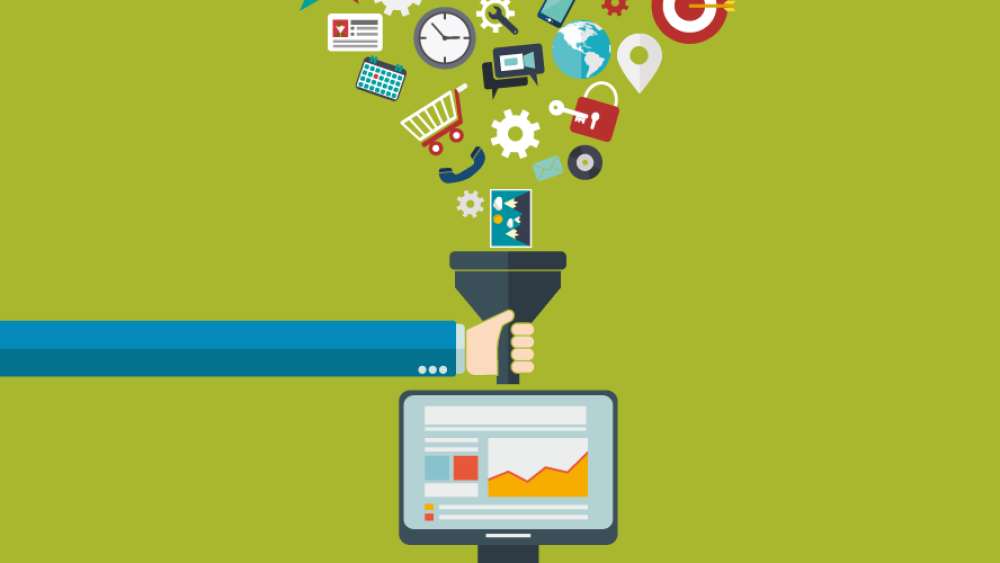

In [13]:
from IPython.display import Image

Image("/kaggle/input/graph-age-images/processing relevant data.png")

# Collecting information about cpg sites

## extra information added
### ***caveat*** : all positional information are Chromosome(Chr) based so distances and position all are chromosome specific so processing done accrodingly please don't use it in inter chromosome relationship purpose
* normalized *start position of CpG Island* base pair named **start_pos_base_pair**
* normalized *end position of CpG Island* base pair named **end_pos_base_pair**
* **MapInfo** which has the average or exact position of the sites
* **CPG_ISLAND** a boolean if the site is a CpG island i.e sequence of Cytosine and Guanine
* CpG Island length **CPG_ISLAND_LEN**
* Distance from Transcription start site is ***Distance_to_TSS*** and we made all NaN values to 0
* **Chr** chromosome number 
* **Symbol** columns tells us the gene name
* **Next_Base** next base pair of the site (C/A/T)
* **SourceStrand**
* ***others***



some normal confusion is what is MapInfo? It is the average base pair position of CpG site and IlmnID is the CpG site and Symbol is the gene name of the site


for more information about the columns of of information please consult with https://drive.google.com/file/d/1tGWUwgCuehbIhf_7uag2XLFjj-2YdEbh/view?usp=drive_link


or


https://tan-dode-7.tiiny.site/




normalized TSS contains NaN values so be careful if you ever want to incorporate them

# Information about cpg sites



In [14]:
file_path = "/kaggle/input/cpgsite-info/GPL8490_HumanMethylation27_270596_v.1.2.csv"

# Read the compressed CSV file into a pandas DataFrame
information = pd.read_csv(file_path,skiprows=7,low_memory=False)

# Now you can work with the DataFrame 'df'
# For example, you can print the first few rows
information.dropna(subset=['Chr'],inplace=True)
information[["start","end"]]=information.CPG_ISLAND_LOCATIONS.fillna("0:0-0").str.split(':').str[1].str.split('-', expand=True).astype(int)
# information.set_index("IlmnID",inplace=True)
information['CPG_ISLAND'] = information['CPG_ISLAND'].astype(int)


In [15]:
information["CPG_ISLAND_LEN"]=information.end-information.start
information.groupby('Chr')['MapInfo'].max().sort_values(ascending=False)
information.MapInfo=information.MapInfo.astype(int)

In [16]:
information.groupby('Chr')['MapInfo'].min().sort_values(ascending=False)
scaler = MinMaxScaler()
information['Normalized_MapInfo'] = information.groupby('Chr')['MapInfo'].transform(lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten())
information['Normalized_TSS_Coordinate'] = information.groupby('Chr')['TSS_Coordinate'].transform(lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten())
information=pd.get_dummies(information,columns=["Gene_Strand"])
information['start']=information.groupby('Chr')['start'].transform(lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten())
information['end']=information.groupby('Chr')['end'].transform(lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten())
information['CPG_ISLAND_LEN']=information.groupby('Chr')['CPG_ISLAND_LEN'].transform(lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten())
information=pd.get_dummies(information,columns=["Next_Base"])
information.Distance_to_TSS.fillna(float("inf"))
information['Distance_to_TSS']=information.groupby('Chr')['Distance_to_TSS'].transform(lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten())
information['Distance_to_TSS']=information['Distance_to_TSS'].fillna(1)
# information['Distance_to_TSS']=1-information['Distance_to_TSS']
information=pd.get_dummies(information,columns=["SourceStrand"])
Chrom=information.Chr.tolist()
information=pd.get_dummies(information,columns=["Chr"])
information['Chr']=Chrom


## all available information (that we prepared) about the CpG sites

In [17]:
information.columns

Index(['IlmnID', 'Name', 'IlmnStrand', 'AddressA_ID', 'AlleleA_ProbeSeq',
       'AddressB_ID', 'AlleleB_ProbeSeq', 'GenomeBuild', 'MapInfo', 'Ploidy',
       'Species', 'Source', 'SourceVersion', 'SourceSeq', 'TopGenomicSeq',
       'Color_Channel', 'TSS_Coordinate', 'Gene_ID', 'Symbol', 'Synonym',
       'Accession', 'GID', 'Annotation', 'Product', 'Distance_to_TSS',
       'CPG_ISLAND', 'CPG_ISLAND_LOCATIONS', 'MIR_CPG_ISLAND', 'MIR_NAMES',
       'Unnamed: 33', 'Unnamed: 34', 'start', 'end', 'CPG_ISLAND_LEN',
       'Normalized_MapInfo', 'Normalized_TSS_Coordinate', 'Gene_Strand_+',
       'Gene_Strand_-', 'Next_Base_A', 'Next_Base_C', 'Next_Base_T',
       'SourceStrand_BOT', 'SourceStrand_TOP', 'Chr_1', 'Chr_10', 'Chr_11',
       'Chr_12', 'Chr_13', 'Chr_14', 'Chr_15', 'Chr_16', 'Chr_17', 'Chr_18',
       'Chr_19', 'Chr_2', 'Chr_20', 'Chr_21', 'Chr_22', 'Chr_3', 'Chr_4',
       'Chr_5', 'Chr_6', 'Chr_7', 'Chr_8', 'Chr_9', 'Chr_X', 'Chr_Y', 'Chr'],
      dtype='object')

#### careful of these columns they have NaN

In [18]:
# Find columns with NaN values
columns_with_nan = information.columns[information.isna().any()].tolist()
columns_with_nan

['TSS_Coordinate',
 'Symbol',
 'Synonym',
 'Accession',
 'GID',
 'Annotation',
 'Product',
 'CPG_ISLAND_LOCATIONS',
 'MIR_CPG_ISLAND',
 'MIR_NAMES',
 'Unnamed: 33',
 'Unnamed: 34',
 'Normalized_TSS_Coordinate']

In [19]:
print(information.columns)

Index(['IlmnID', 'Name', 'IlmnStrand', 'AddressA_ID', 'AlleleA_ProbeSeq',
       'AddressB_ID', 'AlleleB_ProbeSeq', 'GenomeBuild', 'MapInfo', 'Ploidy',
       'Species', 'Source', 'SourceVersion', 'SourceSeq', 'TopGenomicSeq',
       'Color_Channel', 'TSS_Coordinate', 'Gene_ID', 'Symbol', 'Synonym',
       'Accession', 'GID', 'Annotation', 'Product', 'Distance_to_TSS',
       'CPG_ISLAND', 'CPG_ISLAND_LOCATIONS', 'MIR_CPG_ISLAND', 'MIR_NAMES',
       'Unnamed: 33', 'Unnamed: 34', 'start', 'end', 'CPG_ISLAND_LEN',
       'Normalized_MapInfo', 'Normalized_TSS_Coordinate', 'Gene_Strand_+',
       'Gene_Strand_-', 'Next_Base_A', 'Next_Base_C', 'Next_Base_T',
       'SourceStrand_BOT', 'SourceStrand_TOP', 'Chr_1', 'Chr_10', 'Chr_11',
       'Chr_12', 'Chr_13', 'Chr_14', 'Chr_15', 'Chr_16', 'Chr_17', 'Chr_18',
       'Chr_19', 'Chr_2', 'Chr_20', 'Chr_21', 'Chr_22', 'Chr_3', 'Chr_4',
       'Chr_5', 'Chr_6', 'Chr_7', 'Chr_8', 'Chr_9', 'Chr_X', 'Chr_Y', 'Chr'],
      dtype='object')


In [20]:
columns_to_add=["start","end","SourceStrand_TOP","SourceStrand_BOT","Normalized_MapInfo","Gene_Strand_+","Gene_Strand_-","CPG_ISLAND_LEN","Next_Base_A","Next_Base_C","Next_Base_T","Distance_to_TSS" ]
# columns_to_add2=columns_to_add+list(rest)
information.loc[2,:]

IlmnID                                                     cg00003994
Name                                                       cg00003994
IlmnStrand                                                        TOP
AddressA_ID                                                   7150184
AlleleA_ProbeSeq    AATAATAATAATACCCCCTATAATACTAACTAACAAACATACCCTC...
                                          ...                        
Chr_8                                                           False
Chr_9                                                           False
Chr_X                                                           False
Chr_Y                                                           False
Chr                                                                 7
Name: 2, Length: 68, dtype: object

In [21]:
normalized_distance(information.iloc[0,14],information.iloc[0,15])

1.0

In [22]:
columns_to_add

['start',
 'end',
 'SourceStrand_TOP',
 'SourceStrand_BOT',
 'Normalized_MapInfo',
 'Gene_Strand_+',
 'Gene_Strand_-',
 'CPG_ISLAND_LEN',
 'Next_Base_A',
 'Next_Base_C',
 'Next_Base_T',
 'Distance_to_TSS']

In [23]:
sequence_info_str = information.AlleleA_ProbeSeq.astype(str).values

### Function that calculates the normalized levehstein distance between two site Sequence
##### more useful when sequence data of individual will be collected . So urge some researcher to collect such information


In [24]:
from concurrent.futures import ThreadPoolExecutor
# from rapidfuzz import distance as fuzz_distance

def calculate_normalized_distance(args):
    src, distance, sequence_info_str = args
    seq1 = sequence_info_str[src]
    seq2 = sequence_info_str[distance]
    return normalized_distance(seq1, seq2)


In [25]:
len(columns_to_add)

12

In [26]:
information.index=information.IlmnID

In [27]:
information.head()

IlmnID        Name IlmnStrand AddressA_ID  \
IlmnID                                                      
cg00000292  cg00000292  cg00000292        TOP      990370   
cg00002426  cg00002426  cg00002426        TOP     6580397   
cg00003994  cg00003994  cg00003994        TOP     7150184   
cg00005847  cg00005847  cg00005847        BOT     4850717   
cg00006414  cg00006414  cg00006414        BOT     6980731   

                                             AlleleA_ProbeSeq  AddressB_ID  \
IlmnID                                                                       
cg00000292  AAACATTAATTACCAACCACTCTTCCAAAAAACACTTACCATTAAA...    6660678.0   
cg00002426  AATATAATAACATTACCTTACCCATCTTATAATCAAACCAAACAAA...    6100343.0   
cg00003994  AATAATAATAATACCCCCTATAATACTAACTAACAAACATACCCTC...    7150392.0   
cg00005847  TACTATAATACACCCTATATTTAAAACACTAAACTTACCCCATTAA...    1260113.0   
cg00006414  CTCAAAAACCAAACAAAACAAAACCCCAATACTAATCATTAATAAA...    4280093.0   

                                             AlleleB_ProbeSeq  GenomeBuild  \
IlmnID                                                                       
cg00000292  AAACATTAATTACCAACCGCTCTTCCAAAAAACACTTACCATTAAA...         36.0   
cg00002426  AATATAATAACATTACCTTACCCGTCTTATAATCAAACCAAACGAA...         36.0   
cg00003994  AATAATAATAATACCCCCTATAATACTAACTAACAAACATACCCTC...         36.0   
cg00005847  TACTATAATACACCCTATATTTAAAACACTAAACTTACCCCATTAA...         36.0   
cg00006414  CTCGAAAACCGAACAAAACAAAACCCCAATACTAATCGTTAATAAA...         36.0   

              MapInfo   Ploidy  ...  Chr_3  Chr_4  Chr_5  Chr_6  Chr_7  Chr_8  \
IlmnID                          ...                                             
cg00000292   28797601  diploid  ...  False  False  False  False  False  False   
cg00002426   57718583  diploid  ...   True  False  False  False  False  False   
cg00003994   15692387  diploid  ...  False  False  False  False   True  False   
cg00005847  176737319  diploid  ...  False  False  False  False  False  False   
cg00006414  148453770  diploid  ...  False  False  False  False   True  False   

            Chr_9  Chr_X  Chr_Y Chr  
IlmnID                               
cg00000292  False  False  False  16  
cg00002426  False  False  False   3  
cg00003994  False  False  False   7  
cg00005847  False  False  False   2  
cg00006414  False  False  False   7  

[5 rows x 68 columns]

# CPG-> NODE

#### mapping to convert from CpG site name to node number

In [28]:
node2cpg={}
def make_cpg2node(cpg):
    """
    Create a mapping from CpG names to node indices.

    Parameters:
    - cpg (list): List of CpG names.

    Returns:
    - dict: Mapping from CpG names to node indices.
    """
    cpg2node = {}
    for i, c in enumerate(cpg):
        cpg2node[c] = i
        node2cpg[i]=c
    return cpg2node

# Example usage
# Assuming cpg is your list of CpG names
# cpg2node_result = make_cpg2node(cpg)
# print(cpg2node_result)


# Make Graph

## Parameters controlling the comethylation threshold and cpgsite distance for same chromosome

#####  **THRESHOLD_DIST** how much of the same chromosome distance will tertiary threshold be used
##### **THRESHOLD_CORR** applies for all and finds the edegs that have that comethylation 
##### **SECONDARY_THRESHOLD** applies only on the same chromosome
##### **TERTIARY THRESHOLD** applies only in same chromosome and are within the threshold distance
#### lower the threshold for comethylation the better the performance and interpretation but more time consuming## hyperparameters

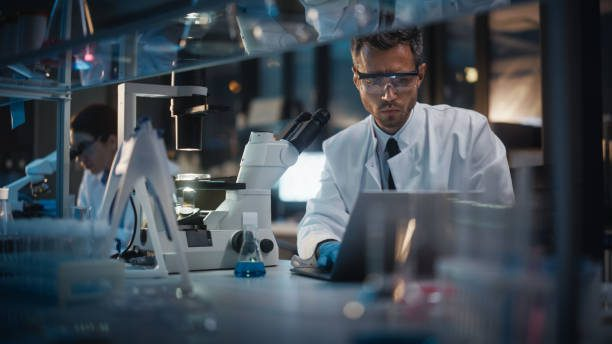

In [29]:
from IPython.display import Image

Image("/kaggle/input/graph-age-images/Medical-Researcher.jpg")


In [30]:
THRESHOLD_DIST=1e5
THRESHOLD_CORR=.7
SECONDARY_THRESHOLD=THRESHOLD_CORR-0.02
TERTIARY_THRESHOLD=THRESHOLD_CORR-0.04

In [31]:
import pandas as pd
from scipy.spatial.distance import pdist, squareform


# Make Graph Section


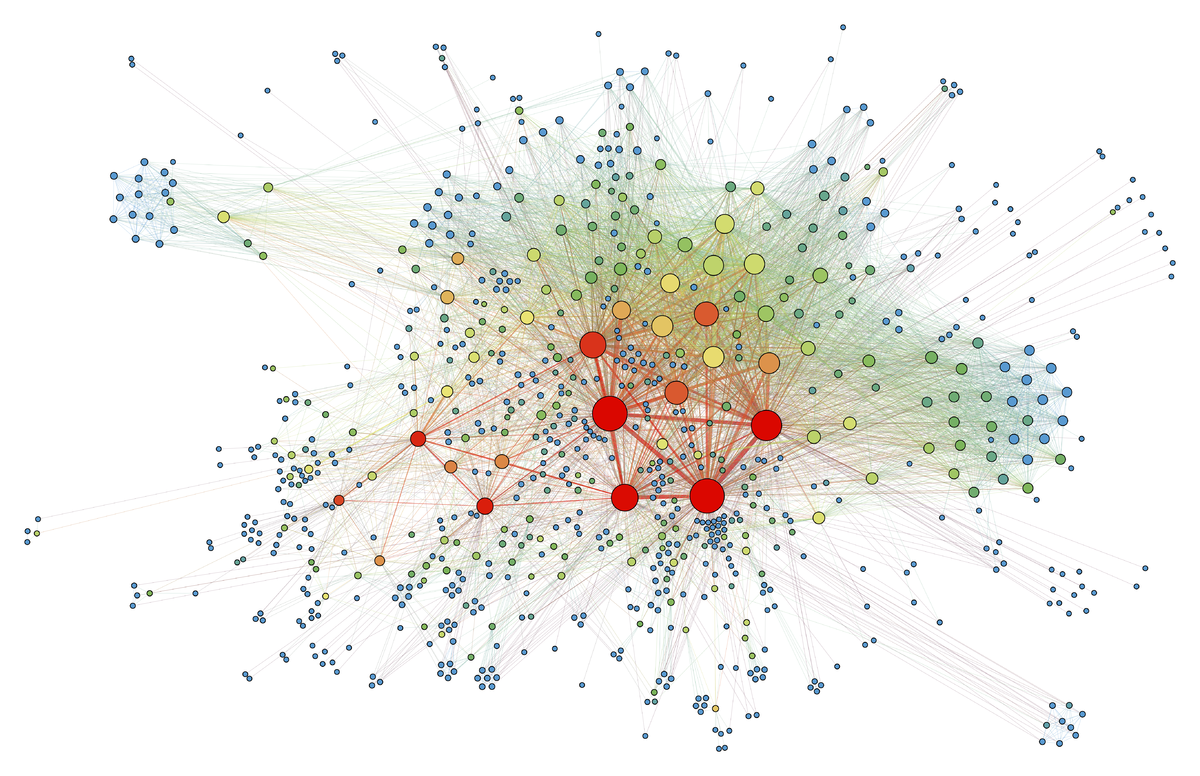

In [32]:
from IPython.display import Image

Image("/kaggle/input/graph-age-images/SocialNetworkAnalysis.png")

## Entire graph edge dimention depends on researcher
if more edge relationship is added please change it

In [33]:
EDGE_DIM=3

## Graph making function
normalized_levistein_sequence_distances is not included if you decide to join please change the edge dimention. Rational behind not adding was that sequence are stationary but when future researchers will collect all these information in conjuction then we can surely add them.

In [34]:
def make_graph(information,threshold_corr,threshold_dist,meth,cpg2node,chromosomes):
    src=[]
    dst=[]
    weights=[]

    chromosomes=information.Chr.values
    genes=information.Symbol.values

    #--------------------------- Making various adjacency-----------------------------
    
    
    # Optimized osseation of the binary adjacency matrix for chromosome information
    print('makeing same chromo adjacency...')
    chromosomes = np.array(chromosomes)
    chromosome_adj = (chromosomes[:, None] == chromosomes).astype(np.float32)
    

    # Distance between CpG sites have to use in conjuction with is_same_chromosome 
    #because they are chromsome based
    
    print('making distance matrix .......')
    base_pair=information.MapInfo.values
    pairwise_distances = pdist(base_pair.reshape(-1, 1))

    # Convert the condensed distance matrix to a square distance matrix
    distance_matrix = squareform(pairwise_distances)
    
    
    
    # Optimized creation of the binary adjacency matrix for chromosome information
    print('makeing same gene adjacency...')
    genes = np.array(genes)
    genes_adj = (genes[:, None] == genes).astype(np.float32)

   
    print('makeing comethylation adjacency...')
    adj=np.corrcoef(meth.to_numpy(),rowvar=False)
    
    
     #*-------------------- Filtering  Edges------------------------------------------------*
    src, dst = np.where((
                        ((chromosome_adj==1)&
                            ((np.abs(adj) > SECONDARY_THRESHOLD)|
                             ((abs(distance_matrix)<threshold_dist)&(np.abs(adj) > TERTIARY_THRESHOLD))
                            )
                         )
                             |(np.abs(adj) > threshold_corr)
                        )&
                        (np.arange(adj.shape[0])[:, None] != np.arange(adj.shape[1])))
    
    # Did not include this researchers can also use this in their approach our not inclusion 
    #reside on the fact that this is common but we think this should be applied when researchers
    # colloect sequence of each samples then use it so model will have mutation information
    
    print('making normalized distance.....')
    sequence_info_str = information.AlleleA_ProbeSeq.astype(str).values
    with ThreadPoolExecutor() as executor:
        normalized_distances = list(executor.map(calculate_normalized_distance, zip(src, dst, [sequence_info_str]*len(src))))
  
    # weights for the edges in the graph
    weights = np.column_stack([adj[src, dst],chromosome_adj[src, dst],genes_adj[src, dst]])
    
    # This is basically the graph with Source and Destination of edges. This is bidirectional
    
    edge_index = [torch.tensor(src, dtype=torch.int64), torch.tensor(dst, dtype=torch.int64)]
    edge_weight=weights
    edge_index = torch.stack(edge_index, dim=0)
    edge_attr = torch.tensor(edge_weight, dtype=torch.float32).reshape(-1,EDGE_DIM)
    print("shape of edge:",edge_index.shape)
    return edge_index,edge_attr

# Feature Processing

# Please Researcher tell me what the node feature should be

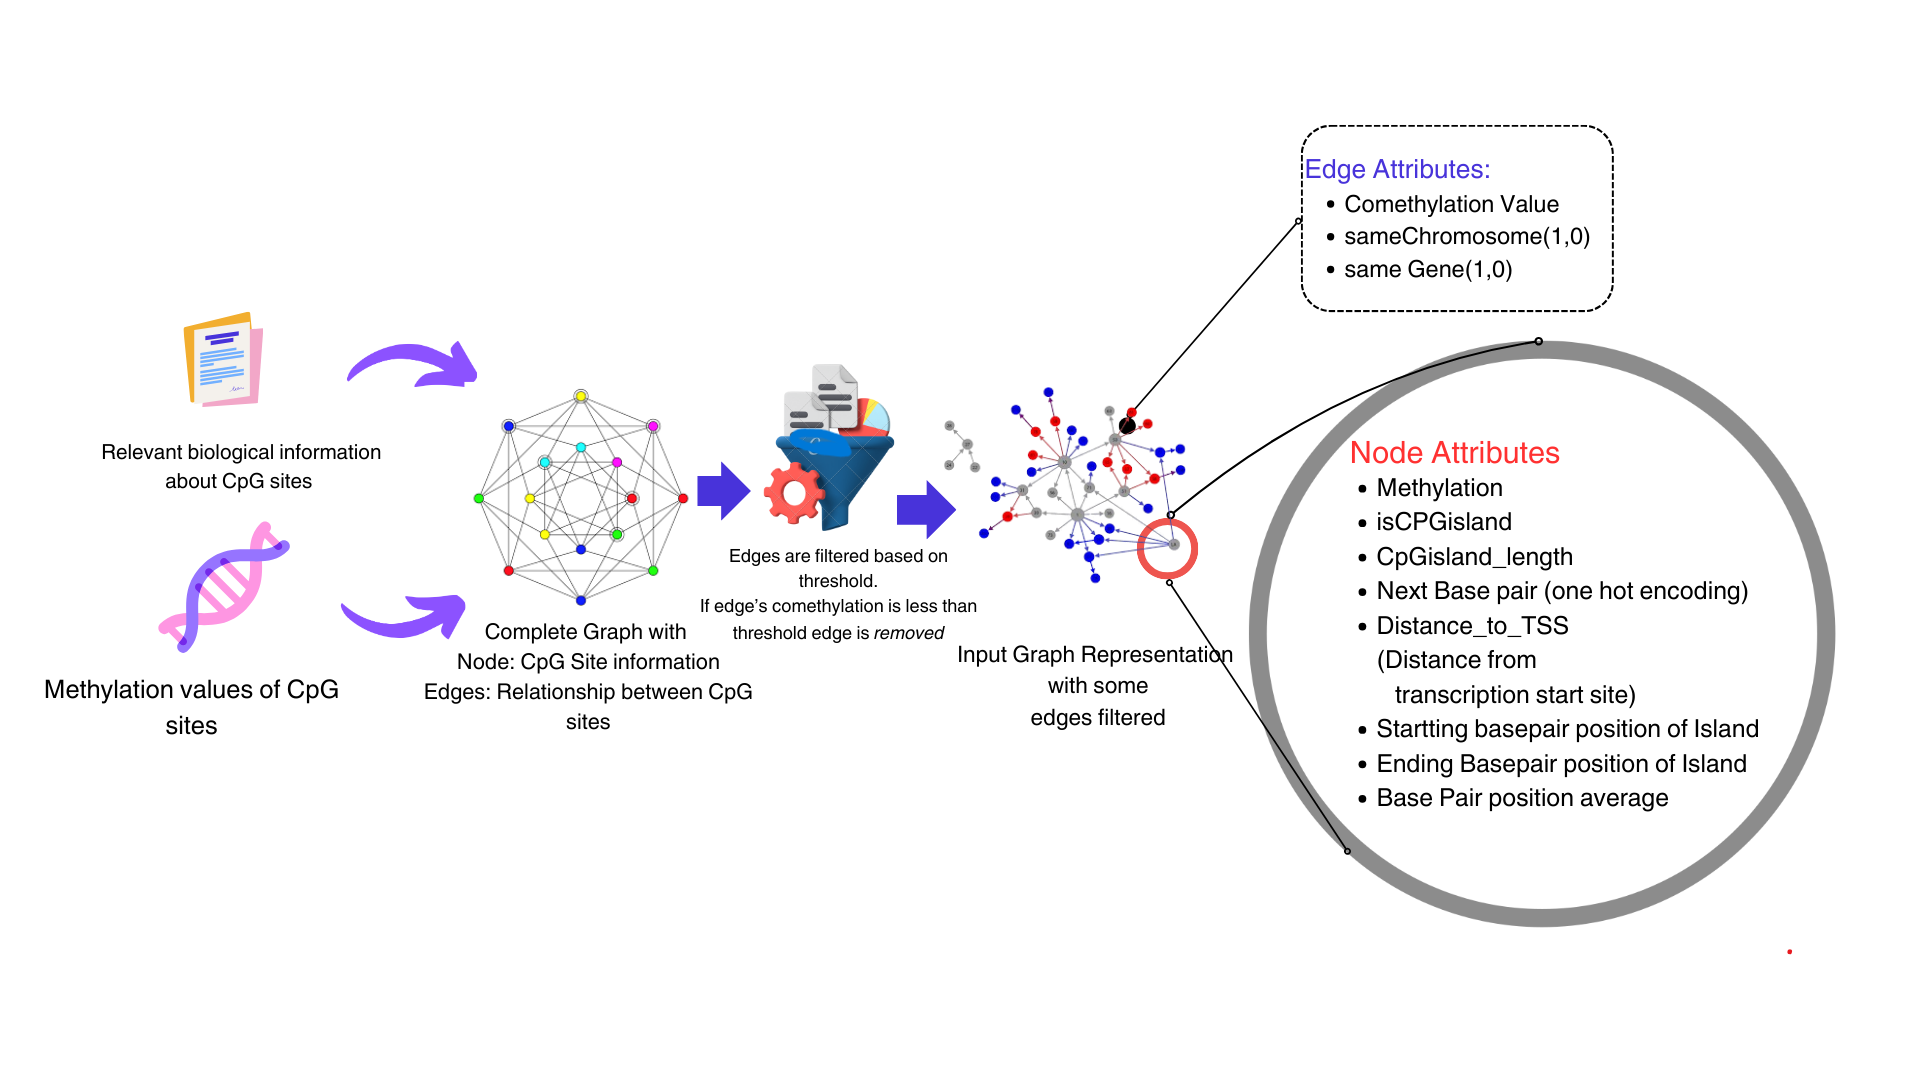

In [35]:
from IPython.display import Image

Image("/kaggle/input/graph-age-images/Node Attributes (7).png")


In [36]:
# Define the available features
NODE_FEATURE_DICT = {
    1: 'CPG_ISLAND',
    2: 'CPG_ISLAND_LEN',
    3: 'Distance_to_TSS',
    4: ["Next_Base_A", "Next_Base_C", "Next_Base_T"],
    5: 'start',
    6: 'end',
    7: 'Normalized_TSS_Coordinate',
    8: 'Normalized_MapInfo',
    9: [f'Chr_{x}' for x in range(1,23)]
}

# Prompt user for input
print("Available features:")
for key, value in NODE_FEATURE_DICT.items():
    print(f"{key}: {value}")
if I_want_to_change_features:
    selected_features = input("Enter the feature numbers you want to include (comma-separated): ")
else:
    selected_features = "1,2,3,4,5,6,8"

# Convert user input to a list of integers
selected_feature_numbers = list(map(int, selected_features.split(',')))

# Create a list of selected features (flattening the sub-list if necessary)
user_selected_features = []
for key in selected_feature_numbers:
    feature = NODE_FEATURE_DICT[key]
    if isinstance(feature, list):
        user_selected_features.extend(feature)
    else:
        user_selected_features.append(feature)

print("User selected features:")
print(user_selected_features)
INPUT_DIM=len(user_selected_features)+1

Available features:
1: CPG_ISLAND
2: CPG_ISLAND_LEN
3: Distance_to_TSS
4: ['Next_Base_A', 'Next_Base_C', 'Next_Base_T']
5: start
6: end
7: Normalized_TSS_Coordinate
8: Normalized_MapInfo
9: ['Chr_1', 'Chr_2', 'Chr_3', 'Chr_4', 'Chr_5', 'Chr_6', 'Chr_7', 'Chr_8', 'Chr_9', 'Chr_10', 'Chr_11', 'Chr_12', 'Chr_13', 'Chr_14', 'Chr_15', 'Chr_16', 'Chr_17', 'Chr_18', 'Chr_19', 'Chr_20', 'Chr_21', 'Chr_22']
User selected features:
['CPG_ISLAND', 'CPG_ISLAND_LEN', 'Distance_to_TSS', 'Next_Base_A', 'Next_Base_C', 'Next_Base_T', 'start', 'end', 'Normalized_MapInfo']


In [37]:
def feature_process(x,information):


    x = pd.concat([x, information[user_selected_features]], axis=1, join='inner')


    # x['CPG_ISLAND'] = x['CPG_ISLAND'].astype(int)


    return torch.tensor(x.to_numpy().astype('float'), dtype=torch.float32)


# Read Organ specific Dataset


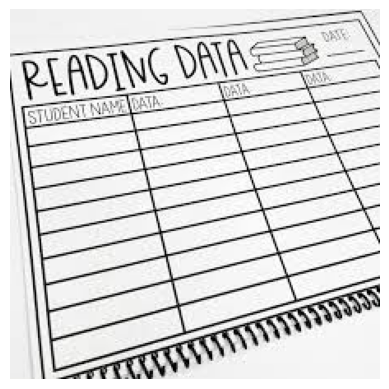

In [38]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread("/kaggle/input/graph-age-images/images (6).jfif")
imgplot = plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()


## Name of datasets

## Dict for edge and attr

In [39]:
Organ_edge={}
Organ_attr={}


# Read Organ specific Dataset

## load dataset

### We have taken common Cpg sites accross multiple platforms 
#### We named them as AltumAge CpG sites because they used this method for selecting CpG sites so we paid tribute
##### But we strongly believe that more sites should be present especially from X and Y chromosomes

In [40]:
AltumAge_cpgs = np.array(pd.read_pickle('/kaggle/input/graph-age/example_dependencies/multi_platform_cpgs.pkl'))
AltumAge_cpgs=AltumAge_cpgs.tolist()

### Helper function to find tissue specific samples

In [41]:
def select(d):
    a = d[d.columns[d.columns.isin(AltumAge_cpgs)].tolist() + ["age",'gender','dataset' ,'tissue_type']]
    # print(a['tissue_type'].unique())
    b = a[a['tissue_type'].str.lower().str.contains('blood')].dropna()
    # print(b)# Assuming you want to print tissue_type of filtered rows
    return b


# Reading the data samples

In [42]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split

# Specify the folder path
# folder_paths = ['/kaggle/input/all-organs4/all_organs','/kaggle/input/new-data-for-blood/Healtthy Normalized']
folder_paths = ['/kaggle/input/all-organs4/all_organs']

# Initialize empty lists to store train and test DataFrames
train_frames = []
test_frames = []

count = 0
# Step 1: Load PKL files into DataFrames
for folder_path in folder_paths:
    for filename in os.listdir(folder_path):
        if filename.endswith(".pkl") :
            file_path = os.path.join(folder_path, filename)
            df = select(pd.read_pickle(file_path))
            if(len(df)<=0):
                continue
            count+=len(df)
            # Step 2: Split each DataFrame into train and test
            train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

            # Append train and test DataFrames to lists
            train_frames.append(train_df)
            test_frames.append(test_df)

# # Step 3: Concatenate all train and test DataFrames
train_combined = pd.concat(train_frames)
test_combined = pd.concat(test_frames)

# # Step 4: Split the combined train DataFrame into train and validation sets
train_data, val_data = train_test_split(train_combined, test_size=0.2, random_state=42)

# Now, train_data, val_data, and test_combined are ready for further use

print("total samples: ",count)

total samples:  3707


In [43]:
len(train_data)

2360

## Make Cpg2Node

In [44]:
cpg2node=make_cpg2node(AltumAge_cpgs)
# cpg2Node

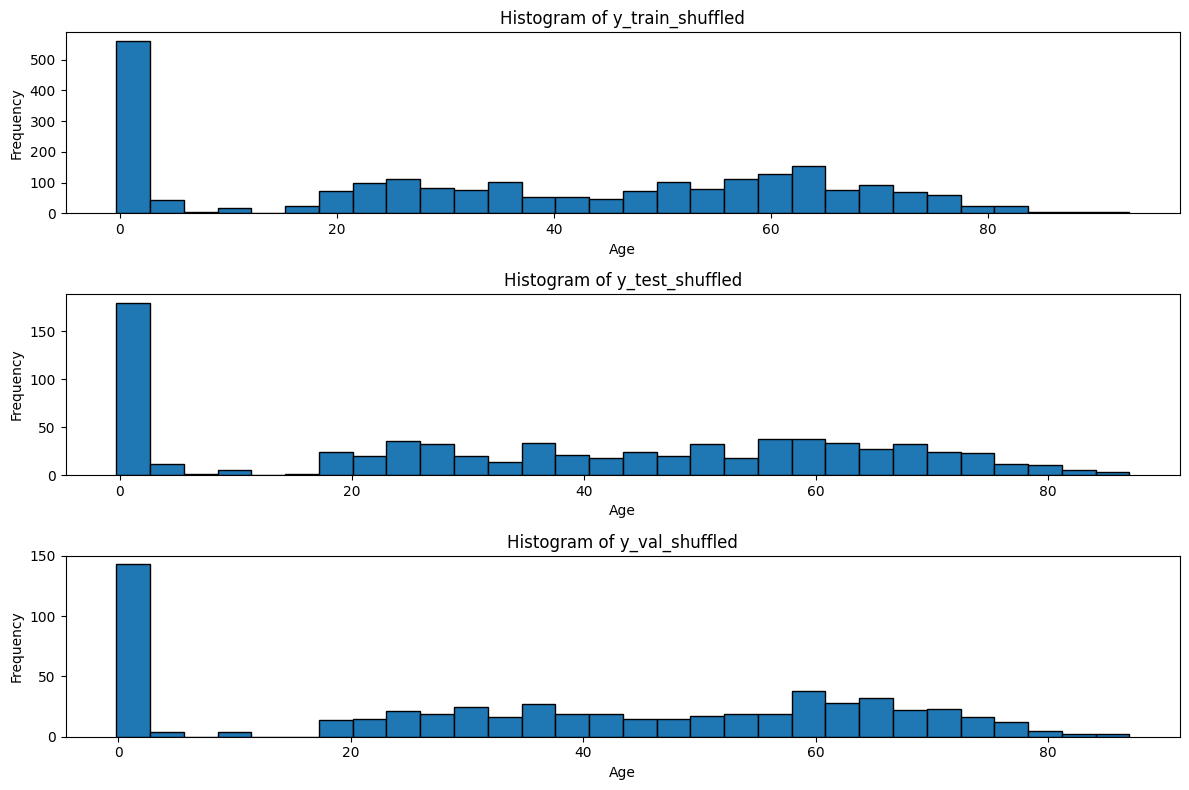

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming y_train_shuffled, y_test_shuffled, y_val_shuffled are your target variables
# Replace this with your actual target variables

# Plot histograms for train, test, and val
plt.figure(figsize=(12, 8))

# Plot for y_train_shuffled
plt.subplot(3, 1, 1)
plt.hist(train_data.age, bins=30, edgecolor='black')
plt.title('Histogram of y_train_shuffled')
plt.xlabel('Age')

plt.ylabel('Frequency')

# Plot for y_test_shuffled
plt.subplot(3, 1, 2)
plt.hist(test_combined.age, bins=30, edgecolor='black')
plt.title('Histogram of y_test_shuffled')
plt.xlabel('Age')
plt.ylabel('Frequency')

# Plot for y_val_shuffled
plt.subplot(3, 1, 3)
plt.hist(val_data.age, bins=30, edgecolor='black')
plt.title('Histogram of y_val_shuffled')
plt.xlabel('Age')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


## X and Y conversion

In [46]:
selected_columns=AltumAge_cpgs
X_train=train_data.drop(columns=["age",'gender','dataset','tissue_type']).astype('float')
y_train=train_data.age
X_test=test_combined.drop(columns=["age",'gender','dataset','tissue_type']).astype('float').astype('float')
y_test=test_combined.age
X_val=val_data.drop(columns=["age",'gender','dataset','tissue_type']).astype('float')
y_val=val_data.age


In [47]:
test_combined.gender

GSM1299708    M
GSM1299748    F
GSM1299717    F
GSM1300377    F
GSM1299799    F
             ..
GSM1363624    F
GSM1363630    M
GSM1363639    M
GSM1363638    M
GSM1363618    F
Name: gender, Length: 756, dtype: object

In [48]:
np.save('ytest',y_test)

In [49]:
len(X_train)

2360

In [50]:
import numpy as np
import matplotlib.pyplot as plt

def plot_value_distribution(tensor):
    # Flatten the tensor to 1D array
    flattened_tensor = tensor.flatten()

    # Calculate unique values and their frequencies
    unique_values, value_counts = np.unique(flattened_tensor, return_counts=True)

    # Plot the distribution
    plt.figure(figsize=(8, 6))
    plt.bar(unique_values, value_counts, color='blue', alpha=0.7)
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.title('Distribution of Values')
    plt.grid(True)
    plt.show()

# Example usage:
# Assuming 'tensor' is your input tensor
# plot_value_distribution(tensor)


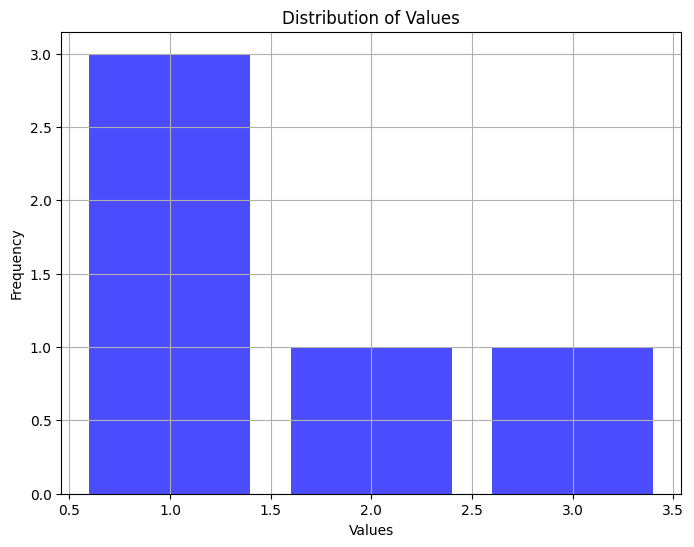

In [51]:
plot_value_distribution(torch.tensor([1,2,3,1,1]))

In [52]:
filtered_information=information[information.IlmnID.isin(selected_columns)]
chromosomes=list(set(filtered_information.Chr))
# cur_edge_index,cur_edge_attr=make_graph(filtered_information,THRESHOLD_CORR,THRESHOLD_DIST,X_train,cpg2node,chromosomes)
# cur_edge_index

In [53]:
# len(cur_edge_attr)

In [54]:
# plot_value_distribution(cur_edge_index[0])

In [55]:
# cur_edge_index[1].size()

### sanity check not relevent

In [56]:
def has_distinct_pairs(tensor):
    pairs_set = set()
    for col in tensor.T:  # Transpose the tensor to iterate over columns
        pair = tuple(col)
        if pair in pairs_set:
            return False
        pairs_set.add(pair)
    print(len(pairs_set))
    # Check if (j, i) is present for every (i, j) pair in pairs_set
    for pair in pairs_set:
        reverse_pair = (pair[1], pair[0])
        if reverse_pair in pairs_set == False:
            return False

    return True

# Example usage:
import numpy as np

# Example tensor
tensor = np.array([[1, 2, 3, 2],
                   [2, 2, 4, 2]])

result = has_distinct_pairs(tensor)
print("Distinct pairs in all columns with reverse pairs:", result)


Distinct pairs in all columns with reverse pairs: False


In [57]:
# sorted_tensor = np.sort(cur_edge_index, axis=1)

In [58]:
# has_distinct_pairs(cur_edge_index)

In [59]:
geneID=filtered_information[filtered_information.Chr=='1'].GID.values
all_cpgs=filtered_information[filtered_information.Chr=='1'].IlmnID.values

In [60]:
# # Create a matrix where geneID is equal to 1 and else 0
# num_genes = len(np.unique(geneID))
# print(num_genes)
# gene_matrix = np.zeros((len(all_cpgs), num_genes))
# for i, gene in enumerate(np.unique(geneID)):
#     gene_matrix[:, i] = (geneID == gene).astype(int)
# # Print the resulting gene matrix
# print("Gene Matrix:")
# print(gene_matrix)


In [61]:
# Organ_edge["whole_blood"]=cur_edge_index
# Organ_attr["whole_blood"]=cur_edge_attr

# Helper function section

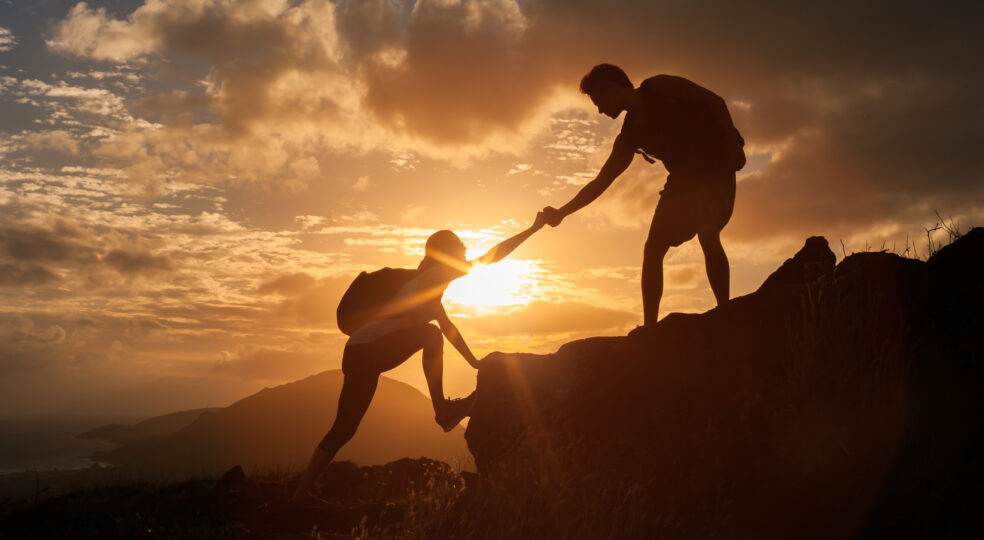

In [62]:
from IPython.display import Image

Image("/kaggle/input/graph-age-images/helper.jpg")


## Helper function to make loaders for the graph gives data to model from these loaders

#### batchsize 1 for stochaistic gradient 

In [63]:
def data_loader_maker(X_,y_,edge_index,edge_attr,filtered_information,batch_size=1):
  current_graph=[]
  for row in range(len(X_)):
    # Create torch tensors
    x = feature_process(X_.iloc[row, :],filtered_information)
    y = torch.tensor(y_.iloc[row], dtype=torch.float32)
    # Create the PyTorch Geometric Data object
    graph = Data(x=x, y=y, edge_index=edge_index, edge_attr=edge_attr)
    # print(graph.x)
    current_graph.append(graph)
    del graph
  # graph_data.extend(current_graph)

  cur_loader= DataLoader(current_graph,batch_size=batch_size)
  del current_graph
  return cur_loader




In [64]:
X_train.columns

Index(['cg00000292', 'cg00002426', 'cg00003994', 'cg00007981', 'cg00008493',
       'cg00008713', 'cg00009407', 'cg00011459', 'cg00012199', 'cg00012386',
       ...
       'cg27650175', 'cg27650434', 'cg27652350', 'cg27653134', 'cg27654142',
       'cg27655905', 'cg27657283', 'cg27662379', 'cg27662877', 'cg27665659'],
      dtype='object', length=20318)

## Make all loaders

In [65]:
# train_loader=data_loader_maker(X_train,y_train,Organ_edge["whole_blood"],Organ_attr["whole_blood"],filtered_information,batch_size=1)
# test_loader=data_loader_maker(X_test,y_test,Organ_edge["whole_blood"],Organ_attr["whole_blood"],filtered_information,batch_size=1)
# val_loader=data_loader_maker(X_val,y_val,Organ_edge["whole_blood"],Organ_attr["whole_blood"],filtered_information,batch_size=1)



In [66]:
# for d in train_loader:
#   print(d.x.shape)

##  PNA GNN needs the degree for it's operation so we calculate it with the help of this function
##### if other GNN is used might not be needed## Some Preprocess for model

In [67]:
import torch

def compute_max_in_degree_and_histogram(train_data_loader):
    """
    Compute the maximum in-degree and in-degree histogram tensor from the given training data loader.

    Parameters:
    - train_data_loader (torch.utils.data.DataLoader): DataLoader for the training data.

    Returns:
    - int: Maximum in-degree.
    - torch.Tensor: In-degree histogram tensor.
    """
    device = torch.device("cpu")

    max_degree = -1
    num_of_nodes = 0

    # Compute the maximum in-degree and total number of nodes
    for idx, data in enumerate(train_data_loader):
        edge_index = data.edge_index[1].to(device)
        max_degree = max(max_degree, int(edge_index.max()))
        num_of_nodes += data.num_nodes

        # Print progress information
        if (idx + 1) % 100 == 0:  # Adjust the frequency of print statements
            print(f"Processed {idx + 1} batches, {num_of_nodes} nodes so far...")
        break

    # Compute the in-degree histogram tensor
    deg = torch.zeros(max_degree + 1, dtype=torch.long, device=device)
    for idx, data in enumerate(train_data_loader.dataset):
        edge_index = data.edge_index[1].to(device)
        d = torch.bincount(edge_index, minlength=max_degree + 1).to(device)
        deg += d

        # Print progress information
        if (idx + 1) % 100 == 0:  # Adjust the frequency of print statements
            print(f"Processed {idx + 1} samples...")

    return max_degree, deg

# Call the function
# max_degree, deg = compute_max_in_degree_and_histogram(train_loader)


# Model  Section# Model

In [68]:
input_dimentions=INPUT_DIM
number_of_cpgs=len(selected_columns)

# Architecture

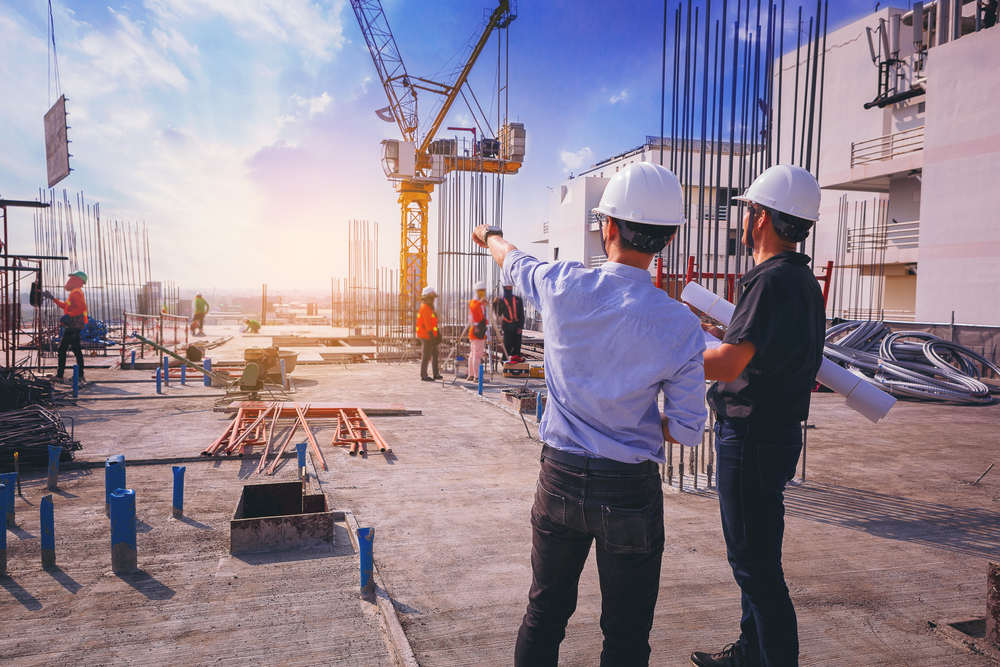

In [69]:
from IPython.display import Image

Image("/kaggle/input/graph-age-images/architecture.jpg")


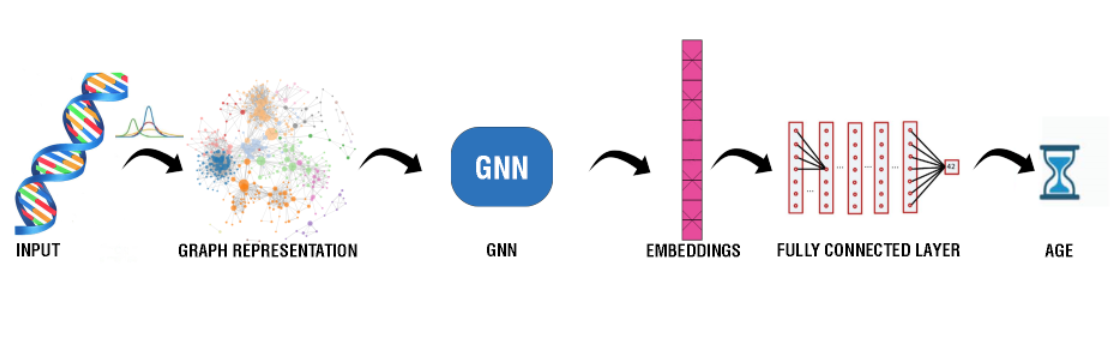

In [70]:
from IPython.display import Image

Image("/kaggle/input/graph-age-images/process.png")


In [71]:

from torch import nn
class Net(torch.nn.Module):
    def __init__(self,deg):

        super().__init__()


        # self.node_emb = Embedding(21, 75)
        # self.edge_emb = Embedding(4, 50)

        aggregators = ['mean', 'max', 'std','min']
        scalers = ['identity', 'amplification','attenuation']

        self.convs = ModuleList()
        self.batch_norms = ModuleList()

        for i in range(0):
          conv = PNAConv(in_channels=input_dimentions, out_channels=input_dimentions,
                          aggregators=aggregators, scalers=scalers, deg=deg,
                          edge_dim=EDGE_DIM, towers=1, pre_layers=1, post_layers=1,
                          divide_input=False)
          self.convs.append(conv)

          if i%3==0:
            self.batch_norms.append(BatchNorm(input_dimentions))
        self.LastLayer=PNAConv(in_channels=input_dimentions, out_channels=1,
                          aggregators=aggregators, scalers=scalers, deg=deg,
                          edge_dim=EDGE_DIM, towers=1, pre_layers=1, post_layers=1,
                          divide_input=False)

        # Define each layer separately
        layers = [
            nn.Linear(number_of_cpgs, 1024),
            nn.ReLU(),
            nn.Linear(1024, 656),
            nn.SELU(),
            nn.Linear(656, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 124),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(124, 64),
            nn.SELU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
        ]
        # self.mlp = nn.Sequential(Linear(number_of_cpgs,1024),ReLU(),Linear(1024,656),SELU(),Linear(656,256),ReLU(),Linear(256,124),ReLU(),Dropout(.2),Linear(124,64),SELU(),Linear(64,32),ReLU(),Linear(32,8),ReLU(),Linear(8,1))
        self.mlp = nn.Sequential(*layers)
#         self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.01)
            elif isinstance(m, PNAConv):
                nn.init.xavier_uniform_(m.lin.weight)
                if m.lin.bias is not None:
                    nn.init.constant_(m.lin.bias, 0.01)
        # self.mlp=Sequential(layers)
    def forward(self, x, edge_index, edge_attr, batch):
        # x = self.node_emb(x.squeeze())
        # edge_attr = self.edge_emb(edge_attr)
        # print(x is not None)
#         print(x.shape)
        if torch.isnan(x).any():
              print(f"NaN values detected before!")
        i=0
        # meth=x.cpu().detach().numpy()
        # plt.scatter(range(len(meth)),meth,color="purple",label="meth")
        # plt.show()
        for conv in self.convs:
            z=conv(x, edge_index, edge_attr)
            # if i%3==0:
            #   z=batch_norm(z)
            x = F.relu(z)
            if torch.isnan(x).any():
              print(f"NaN values detected after layer{i}!")
            i=i+1
        #

        # print(x)
        # emb=global_mean_pool(x, batch)
        z=self.LastLayer(x,edge_index,edge_attr)
        x = F.relu(z)
#         print(x.shape)
#         print(x.sum())
        emb=self.mlp(x.T)
        # print(emb is not None)
        # print(emb.shape)
        # Convert tensors to numpy arrays for plotting
        # Assuming x and emb are PyTorch tensors
        # x_np = x.cpu().detach().numpy()
        # emb_np = emb.cpu().detach().numpy()



        # # Plot both the original tensor x and the output of MLP emb in a single graph
        # plt.figure(figsize=(10, 5))

        # # Plot the original tensor x
        # plt.plot(x_np[1, :], label='Original Tensor x', linewidth=2)

        # # Plot the output of MLP emb
        # plt.plot(emb_np, label='Output of MLP (emb)', linewidth=2)

        # # Add labels and legend
        # plt.xlabel('Index')
        # plt.ylabel('Value')
        # plt.title('Comparison of Original Tensor x and Output of MLP (emb)')
        # plt.legend()

        # plt.show()

        return emb.flatten()




# Net(deg)

### Helper for getting different age groups

In [72]:
def age_group(age):
    if age <= 0:
        return 0
    if age <= 20:
        return 1
    elif age <= 45:
        return 2
    elif age <= 55:
        return 3
    elif age <= 65:
        return 4
    elif age <= 75:
        return 5
    elif age <= 80:
        return 6
    else:
        return 7
    
    

## Train func

In [73]:
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error

def train(train_loader,model,optimizer,criterion,epoch):
    model.train()

    total_loss = 0
    truths = []
    predictions = []
    l=len(train_loader.dataset)
    ages = []
    
    # Initialize dictionaries to store truths and predictions by age group
    age_group_data = {i: {'truths': [], 'predictions': []} for i in range(8)}
    
    for data in tqdm(train_loader, total=len(train_loader), desc=f'Epoch {epoch }/{1000}'):
        data = data.to(device)
        optimizer.zero_grad()

        if torch.isnan(data.x).any():
            print(f"!!!")

        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        loss = criterion(out, data.y.flatten())

        truths.append(data.y.cpu().numpy())
        predictions.append(out.cpu().detach().numpy())
        ages.append(data.y.cpu().numpy())  # Assuming `data.age` exists and contains the age

        loss.backward()
        total_loss += loss.item() * len(data)
        optimizer.step()

    average_loss = total_loss / len(train_loader.dataset)

    # Convert lists to NumPy arrays for plotting
    truths = np.array(truths).flatten()
    predictions = np.array(predictions).flatten()
    ages = np.concatenate(ages).flatten()
    

    # Calculate MAE, MSE, and R2 score
    mae = mean_absolute_error(truths, predictions)
    mse = mean_squared_error(truths, predictions)
    r2 = r2_score(truths, predictions)
    
    # Categorize data by age groups
    for truth, pred, age in zip(truths, predictions, ages):
        group = age_group(age)
        age_group_data[group]['truths'].append(truth)
        age_group_data[group]['predictions'].append(pred)
        # Calculate metrics by age group and store in a DataFrame
    metrics = ['MAE', 'MSE', 'MedAE', 'R2']
    age_g_name=['0','0-20','20-45','45-55','55-65','65-75','75-80','80+']
    data = {metric: [] for metric in metrics}
    for i in range(8):
        group_truths = np.array(age_group_data[i]['truths'])
        group_predictions = np.array(age_group_data[i]['predictions'])
        if len(group_truths) > 0:
            data['MAE'].append(mean_absolute_error(group_truths, group_predictions))
            data['MSE'].append(mean_squared_error(group_truths, group_predictions))
            data['MedAE'].append(median_absolute_error(group_truths, group_predictions))
            data['R2'].append(r2_score(group_truths, group_predictions))
        else:
            data['MAE'].append(None)
            data['MSE'].append(None)
            data['MedAE'].append(None)
            data['R2'].append(None)

    metrics_df = pd.DataFrame(data, index=[f'Age Group {age_g_name[i]}' for i in range(8)])
    
#     print(f'Epoch {epoch + 1}/{1000}, Loss: {average_loss}, MAE: {mae}, MSE: {mse}, R2: {r2}, MedAE: {medae}')
    print(metrics_df)

    
    print(f'Epoch {epoch + 1}/{1000}, Loss: {average_loss}, MAE: {mae}, MSE: {mse}, R2: {r2}')

    # Plot truths vs predictions
    plt.figure(figsize=(10, 5))
    plt.scatter(range(len(train_loader.dataset)), truths, color='blue', label='Truth')
    plt.scatter(range(len(train_loader.dataset)), predictions, color='red', label='Pred')
    plt.xlabel('Truth')
    plt.ylabel('Prediction')
    plt.title(f'Epoch {epoch + 1}/{1000}, Loss: {average_loss}, MAE: {mae}, MSE: {mse}, R2: {r2}\nTruth vs Prediction Scatter Plot')
    plt.legend()
    plt.show()

    return average_loss


In [74]:
# train(1)

## Test func

In [75]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error

@torch.no_grad()
def test(loader, model,criterion,gender=None, epoch=None):
    model.eval()

    total_error = 0
    truths = []
    predictions = []
    ages = []
    genders = []
    age_g_name=['0','0-20','20-45','45-55','55-65','65-75','75-80','80+']
    # Initialize dictionaries to store truths and predictions by age group
    if gender is None:
        age_group_data = {i: {'truths': [], 'predictions': []} for i in range(8)}
    else:
        # Initialize dictionaries to store truths and predictions by age group and gender
        age_gender_group_data = {i: {'M': {'truths': [], 'predictions': []}, 'F': {'truths': [], 'predictions': []}} for i in range(8)}

    for data in tqdm(loader, total=len(loader), desc=f'Epoch {epoch}/{1000}'):
        data = data.to(device)

        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        truths.append(data.y.cpu().numpy())
        predictions.append(out.cpu().detach().numpy())
        ages.append(data.y.cpu().numpy())  # Assuming `data.age` exists and contains the age

        if gender is not None:
            genders=gender  # Assuming `data.gender` exists and contains the gender ('M' or 'F')

        total_error += (out - data.y).abs().sum().item()

    average_loss = total_error / len(loader.dataset)

    # Convert lists to NumPy arrays
    truths = np.concatenate(truths).flatten()
    predictions = np.concatenate(predictions).flatten()
    ages = np.concatenate(ages).flatten()

   

    # Categorize data by age groups and gender if applicable
    if gender is None:
        for truth, pred, age in zip(truths, predictions, ages):
            group = age_group(age)
            age_group_data[group]['truths'].append(truth)
            age_group_data[group]['predictions'].append(pred)

        # Calculate metrics by age group and store in a DataFrame
        metrics = ['MAE', 'MSE', 'MedAE', 'R2', 'num_sample']
        results = []

        for i in range(8):
            group_truths = np.array(age_group_data[i]['truths'])
            group_predictions = np.array(age_group_data[i]['predictions'])
            if len(group_truths) > 0:
                results.append({
                    'Age Group': f'{age_g_name[i]}',
                    'MAE': mean_absolute_error(group_truths, group_predictions),
                    'MSE': mean_squared_error(group_truths, group_predictions),
                    'MedAE': median_absolute_error(group_truths, group_predictions),
                    'R2': r2_score(group_truths, group_predictions),
                    'num_sample': len(group_truths)
                })
            else:
                results.append({
                    'Age Group': f'{age_g_name[i]}',
                    'MAE': None,
                    'MSE': None,
                    'MedAE': None,
                    'R2': None,
                    'num_sample': len(group_truths)
                })

    else:
        for truth, pred, age, gender in zip(truths, predictions, ages, genders):
            group = age_group(age)
#             print('my genser is :',gender)
#             gender = 'M' if gender == 0 else 'F'  # Assuming gender is encoded as 0 for 'M' and 1 for 'F'
            age_gender_group_data[group][gender]['truths'].append(truth)
            age_gender_group_data[group][gender]['predictions'].append(pred)

        # Calculate metrics by age group and gender and store in a DataFrame
        metrics = ['MAE', 'MSE', 'MedAE', 'R2', 'num_sample']
        results = []
        
        for i in range(8):
            for gender in ['M', 'F']:
                group_truths = np.array(age_gender_group_data[i][gender]['truths'])
                group_predictions = np.array(age_gender_group_data[i][gender]['predictions'])
                if len(group_truths) > 0:
                    results.append({
                        'Age Group': age_g_name[i],
                        'Gender': gender,
                        'MAE': mean_absolute_error(group_truths, group_predictions),
                        'MSE': mean_squared_error(group_truths, group_predictions),
                        'MedAE': median_absolute_error(group_truths, group_predictions),
                        'R2': r2_score(group_truths, group_predictions),
                        'num_sample': len(group_truths)
                    })
                else:
                    results.append({
                        'Age Group':age_g_name[i],
                        'Gender': gender,
                        'MAE': 0,
                        'MSE': 0,
                        'MedAE': 0,
                        'R2': 0,
                        'num_sample': 0
                    })

    metrics_df = pd.DataFrame(results)
    
    print(f'Test Results: Epoch {epoch}, Loss: {average_loss}')

    # Plot truths vs predictions
    plt.figure(figsize=(5, 5))
    plt.scatter(range(len(loader.dataset)), truths, color='blue', label='Truth')
    plt.scatter(range(len(loader.dataset)), predictions, color='red', label='Pred')
    plt.xlabel('Sample Index')
    plt.ylabel('Value')
    plt.title(f'Epoch {epoch}, Loss: {average_loss}\nTruth vs Prediction Scatter Plot')
    plt.legend()
    plt.show()

    return average_loss,metrics_df



# Prediction function

In [76]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error

@torch.no_grad()
def predict(loader, model):
    model.eval()

    total_error = 0
    truths = []
    predictions = []
    ages = []
    
    for data in tqdm(loader, total=len(loader)):
        data = data.to(device)

        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        truths.append(data.y.cpu().numpy())
        predictions.append(out.cpu().detach().numpy())
        ages.append(data.y.cpu().numpy())  # Assuming `data.age` exists and contains the age
        total_error += (out - data.y).abs().sum().item()

    average_loss = total_error / len(loader.dataset)

    # Convert lists to NumPy arrays
    truths = np.concatenate(truths).flatten()
    predictions = np.concatenate(predictions).flatten()
    ages = np.concatenate(ages).flatten()
    return predictions




 # Training the model

In [77]:
# !pip install --verbose --no-cache-dir torch-scatter

### Making the process some what deterministic
#### Change device according to need
##### this just determines where the machine will run

In [78]:
import random
# Set random seed for Python's built-in random module
random_seed = 42
random.seed(random_seed)

# Set random seed for NumPy
np.random.seed(random_seed)


# Set random seed for PyTorch on CPU
torch.manual_seed(random_seed)

# Set random seed for PyTorch on GPU (if available)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(random_seed)
#brain lr-3.2e-1 patience 10 factor-.4,lr-1e-4
# Additional steps for improving reproducibility (if needed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## This section was used previously included just to give and idea about our working process ***Not relevant scroll untill you find now relevant*** 

In [79]:
# Define the path where you want to save the model state_dict in your Google Drive
save_path = '/weights/model_brain_state_dict.pth'



## This ensures that all irrelevant cells will be ignored you could also just delete all the cells

In [80]:
model_saved=5

In [81]:
save_path2 = 'model_blood_state_dict.pth'

In [82]:
# model_saved=input('do you have previous saved model in save path2? press 1 if yes else press anything else')

if model_saved==1 or model_saved==3 :
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  # Create model, optimizer, and criterion with current hyperparameters
  model = Net(deg).to(device)
  save_path="/kaggle/input/checkpoint-new/checkpoint (14).pth"
  # Load the state_dict into the model
  model.load_state_dict(torch.load(save_path))

  best_model_state_dict=torch.load('/kaggle/input/checkpoint-new/model_blood_state_dict (5).pth')
  best_val_loss=test(val_loader,model)
#   test(test_loader,model)
else:
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#   model = Net(deg).to(device)
  best_models = None
  best_val_loss=np.inf
            
        



In [83]:
# test(test_loader,model,list(test_combined.gender.fillna('M').values))

In [84]:
# test(test_loader,model)

In [85]:
if model_saved ==1 or model_saved==2:
    from sklearn.model_selection import ParameterGrid
    import random
    # Set random seed for Python's built-in random module
    random_seed = 42
    random.seed(random_seed)

    # Set random seed for NumPy
    np.random.seed(random_seed)


    # Set random seed for PyTorch on CPU
    torch.manual_seed(random_seed)

    # Set random seed for PyTorch on GPU (if available)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(random_seed)
    #brain lr-3.2e-1 patience 10 factor-.4,lr-1e-4
    # Additional steps for improving reproducibility (if needed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Define your hyperparameter grid
    param_grid = {
        'lr': [.8e-4,0.001, 0.005, 0.001],
        'weight_decay': [ 5e-5,2e-3,1e-3,5e-2],
        'min_lr': [  10e-8],
        'patience': [ 10, 15],
        'factor': [.9]
    }


    results_list = []
    num_epochs=300


    print('starting')
    for params in ParameterGrid(param_grid):
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # Create model, optimizer, and criterion with current hyperparameters
        optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])
        criterion = torch.nn.MSELoss()

        # Create scheduler with current hyperparameters
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=params['factor'], patience=params['patience'], min_lr=params['min_lr'])

        # Training loop
        # best_val_loss = float('inf')
        # best_model_state_dict = None
        losses = {'train': [], 'val': [], 'test': []}

        for epoch in range(1, num_epochs + 1):
            # Your training code here, assuming `train` function trains one epoch
            loss = train(epoch,model)

            # Validation and test
            val_loss,val_metric = test(val_loader,model,None,epoch)
            test_loss,test_metric = test(test_loader,model,None,epoch)

            scheduler.step(val_loss)

            # Save the best model
            if val_loss < best_val_loss and test_loss <= 5 :
                best_val_loss = val_loss
                print(val_loss,best_val_loss)
                best_model_state_dict = model.state_dict()
                # Save the model state_dict to the specified path
                torch.save(best_model_state_dict, save_path2)
#                 val_metric
                
            if epoch%10==0:
                torch.save(model.state_dict(), "checkpoint.pth")

            # Record losses
            losses['train'].append(loss)
            losses['val'].append(val_loss)
            losses['test'].append(test_loss)

            print(f'Epoch:{params} {epoch:02d}, Training Loss: {loss:.4f}, Val Loss: {val_loss:.4f}, Test Loss: {test_loss:.4f}')

        # Save the best models
        if best_model_state_dict is not None:
            best_models.append({
                'params': params,
                'state_dict': best_model_state_dict,
                'val_loss': best_val_loss,
            })

        # Store results in a list
        result_entry = {
            'params': params,
            'best_val_loss': best_val_loss,
            'best_test_loss': test_loss,
        }

        results_list.append(result_entry)

    # Plotting
    for idx, model_entry in enumerate(best_models):
        plt.plot(losses['train'], label=f'Train Loss (Model {idx + 1})')
        plt.plot(losses['val'], label=f'Val Loss (Model {idx + 1})')
        plt.plot(losses['test'], label=f'Test Loss (Model {idx + 1})')

    plt.legend()

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Losses of Best Models')
    plt.show()

    # Create a CSV file with various results
    results_df = pd.DataFrame(results_list)
    results_df.to_csv('hyperparameter_results.csv', index=False)

In [86]:
import torch
from torch_geometric.data import DataLoader
from sklearn.model_selection import KFold, ParameterGrid
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Assuming your data loader maker function and other necessary functions are defined
# e.g., data_loader_maker, train, test, compute_max_in_degree_and_histogram


In [87]:
type(train_combined)

pandas.core.frame.DataFrame

In [88]:
train_combined[train_combined.gender=='gender']

Empty DataFrame
Columns: [cg00000292, cg00002426, cg00003994, cg00007981, cg00008493, cg00008713, cg00009407, cg00011459, cg00012199, cg00012386, cg00013618, cg00014085, cg00014837, cg00015770, cg00021527, cg00022866, cg00024396, cg00024812, cg00025991, cg00027083, cg00027674, cg00029826, cg00031162, cg00032227, cg00033773, cg00034039, cg00035347, cg00035623, cg00037763, cg00037940, cg00040861, cg00040873, cg00043004, cg00043080, cg00044245, cg00047050, cg00047469, cg00050312, cg00051979, cg00054706, cg00056767, cg00057593, cg00058938, cg00059424, cg00059930, cg00060762, cg00062776, cg00063144, cg00065385, cg00065408, cg00066816, cg00067471, cg00069261, cg00072216, cg00075967, cg00076645, cg00077877, cg00078194, cg00079056, cg00079563, cg00080012, cg00081935, cg00083937, cg00084687, cg00091693, cg00094851, cg00095526, cg00096922, cg00097536, cg00098162, cg00103783, cg00105253, cg00105470, cg00107187, cg00107488, cg00107632, cg00108454, cg00112517, cg00113951, cg00116234, cg00116838, cg00117172, cg00119079, cg00121158, cg00121640, cg00123035, cg00126034, cg00128560, cg00128654, cg00128877, cg00129774, cg00131557, cg00132141, cg00133909, cg00134787, cg00135056, cg00136105, cg00136477, cg00136736, cg00138126, ...]
Index: []

[0 rows x 20322 columns]

In [89]:
# X_train=train_data.drop(columns=["age",'gender','dataset','tissue_type']).astype('float')
# y_train=train_data.age
# X_test=test_combined.drop(columns=["age",'gender','dataset','tissue_type']).astype('float').astype('float')
# y_test=test_combined.age
# X_val=val_data.drop(columns=["age",'gender','dataset','tissue_type']).astype('float')
# y_val=val_data.age
# print('making edges....')
# cur_edge_index,cur_edge_attr=make_graph(filtered_information,THRESHOLD_CORR,THRESHOLD_DIST,X_train,cpg2node,chromosomes)

# Organ_edge["whole_blood"]=cur_edge_index
# Organ_attr["whole_blood"]=cur_edge_attr
# print('making loaders......')
# # Create DataLoaders
# train_loader=data_loader_maker(X_train,y_train,Organ_edge["whole_blood"],Organ_attr["whole_blood"],filtered_information,batch_size=1)
# test_loader=data_loader_maker(X_test,y_test,Organ_edge["whole_blood"],Organ_attr["whole_blood"],filtered_information,batch_size=1)
# val_loader=data_loader_maker(X_val,y_val,Organ_edge["whole_blood"],Organ_attr["whole_blood"],filtered_information,batch_size=1)


# print('degree calculating.....')
# # Compute degree info
# max_degree, deg = compute_max_in_degree_and_histogram(train_loader)

# # Initialize model, optimizer, criterion, and scheduler
# model = Net(deg).to(device)

In [90]:
# params = {
#     'lr': [1.e-4],
#     'weight_decay': [ 7e-2],
#     'min_lr': [  10e-12],
#     'patience': [ 5],
#     'factor': [.7]
# }

In [91]:
# save_path="/kaggle/input/weights-2/best_model.pth"
# # Load the state_dict into the model
# model.load_state_dict(torch.load(save_path))

In [92]:
# # optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])
# criterion = torch.nn.MSELoss()
# # model.load
# test(val_loader, model, criterion,val_data.gender.tolist(),0)

In [93]:
del X_train,X_test,X_val

## Now Relevant

## This function helps to download automatically useful because Kaggle stops working for some reason

In [94]:
from IPython.display import FileLink, display, HTML, Javascript

def trigger_download(filename, my_id=0):
    # Create the FileLink object
    file_link = FileLink(filename)

    # Get the path of the file
    file_path = file_link.path

    # Create the HTML link
    html = f'<a id="download_link_{file_path}_{my_id}" href="{file_path}" download>{file_path}</a>'

    # Display the HTML link
    display(HTML(html))

    # Create and run the JavaScript to automatically click the link
    js_code = f'''
    var link = document.getElementById('download_link_{file_path}_{my_id}');
    link.click();
    '''
    display(Javascript(js_code))




In [95]:
!echo 'sada2323hjs'>asd.txt

In [96]:
# Test the function
trigger_download('asd.txt')

<IPython.core.display.Javascript object>

### Helper to see the learning rate . So after stopping and restarting by loading the weights of the weight in the model we set the learning rate to the value it was when it stopped running

In [97]:
def print_learning_rate(optimizer):
    for i, param_group in enumerate(optimizer.param_groups):
        print(f"Learning rate for parameter group {i}: {param_group['lr']}")

In [98]:
# test(val_loader, model, criterion,val_data.gender.tolist(),epoch)

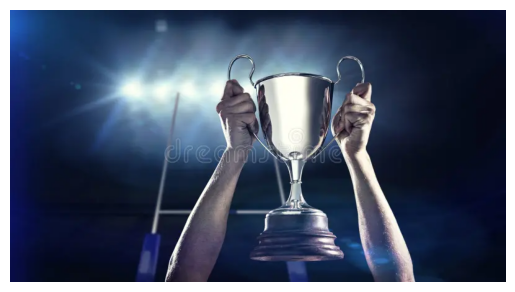

In [99]:

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread("/kaggle/input/graph-age-images/champion.webp")
imgplot = plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()

## Function to load the best model

In [100]:
import random
desired_fold=2
def best_model_test( data_list,test_data ,num_epochs=100, k=5, save_path2='best_model.pth'):
    results_list = []
    best_models = []

    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    data_array = data_list

    fold_losses = {'train': [], 'val': [], 'test': []}
    best_val_loss = float('inf')
    best_model_state_dict = None

    for fold, (train_index, val_index) in enumerate(kf.split(data_array)):
        if fold!=desired_fold:
            continue
        print(f"Starting fold {fold + 1}/{k}")
        print(train_index)
        # Split the data
        train_data = data_array.iloc[train_index,:].sample(frac=1)
        val_data = data_array.iloc[val_index,:]
        test_combined = test_data

        print('starting...')
        X_train=train_data.drop(columns=["age",'gender','dataset','tissue_type']).astype('float')
        y_train=train_data.age
        X_test=test_combined.drop(columns=["age",'gender','dataset','tissue_type']).astype('float').astype('float')
        y_test=test_combined.age
        X_val=val_data.drop(columns=["age",'gender','dataset','tissue_type']).astype('float')
        y_val=val_data.age
        print('making edges....')
        cur_edge_index,cur_edge_attr=make_graph(filtered_information,THRESHOLD_CORR,THRESHOLD_DIST,X_train,cpg2node,chromosomes)

        Organ_edge["whole_blood"]=cur_edge_index
        Organ_attr["whole_blood"]=cur_edge_attr
        print('making loaders......')
        # Create DataLoaders
        train_loader=data_loader_maker(X_train,y_train,Organ_edge["whole_blood"],Organ_attr["whole_blood"],filtered_information,batch_size=1)
        test_loader=data_loader_maker(X_test,y_test,Organ_edge["whole_blood"],Organ_attr["whole_blood"],filtered_information,batch_size=1)
        val_loader=data_loader_maker(X_val,y_val,Organ_edge["whole_blood"],Organ_attr["whole_blood"],filtered_information,batch_size=1)

        criterion = torch.nn.MSELoss()
        print('degree calculating.....')
        # Compute degree info
        max_degree, deg = compute_max_in_degree_and_histogram(train_loader)

        # Initialize model, optimizer, criterion, and scheduler
        model = Net(deg).to(device)
        save_path="/kaggle/input/checkpoint/best_model_fold_2_thre_0.7 cur best 3.pth"
        # Load the state_dict into the model
        model.load_state_dict(torch.load(save_path))
        best_val_loss ,_ = test(val_loader, model, criterion,val_data.gender.tolist(),0)
#         test_loss,_=test(val_loader, model, criterion,val_data.gender.tolist(),0)
        best_model_state_dict = model.state_dict()
        return model


# load best model

Starting fold 3/5
[   0    1    3 ... 2947 2949 2950]
starting...
making edges....
makeing same chromo adjacency...
making distance matrix .......
makeing same gene adjacency...
makeing comethylation adjacency...
making normalized distance.....
shape of edge: torch.Size([2, 4558878])
making loaders......


/opt/conda/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/opt/conda/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/opt/conda/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


degree calculating.....
Processed 100 samples...
Processed 200 samples...
Processed 300 samples...
Processed 400 samples...
Processed 500 samples...
Processed 600 samples...
Processed 700 samples...
Processed 800 samples...
Processed 900 samples...
Processed 1000 samples...
Processed 1100 samples...
Processed 1200 samples...
Processed 1300 samples...
Processed 1400 samples...
Processed 1500 samples...
Processed 1600 samples...
Processed 1700 samples...
Processed 1800 samples...
Processed 1900 samples...
Processed 2000 samples...
Processed 2100 samples...
Processed 2200 samples...
Processed 2300 samples...


Epoch 0/1000: 100%|██████████| 590/590 [01:12<00:00,  8.17it/s]


Test Results: Epoch 0, Loss: 3.281905351449751


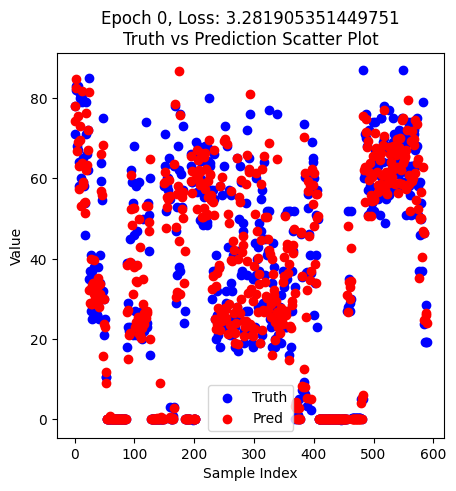

In [101]:
model=best_model_test(train_combined,test_combined ,num_epochs=150, k=5, save_path2='best_model.pth')


## Helper function to get the loaders 
### edge index and edge attr you must keep in mind that the edges are very much dependant on the training data so be careful which loader and edge index you use

In [102]:
def get_loaders_deg_edges(desired_fold, data_list,test_data ,num_epochs=100, k=5):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    data_array = data_list

    fold_losses = {'train': [], 'val': [], 'test': []}
    best_val_loss = float('inf')
    best_model_state_dict = None

    for fold, (train_index, val_index) in enumerate(kf.split(data_array)):
        if fold!=desired_fold:
            continue
        print(f"Starting fold {fold + 1}/{k}")
        print(train_index)
        # Split the data
        train_data = data_array.iloc[train_index,:].sample(frac=1)
        val_data = data_array.iloc[val_index,:]
        test_combined = test_data

        print('starting...')
        X_train=train_data.drop(columns=["age",'gender','dataset','tissue_type']).astype('float')
        y_train=train_data.age
        X_test=test_combined.drop(columns=["age",'gender','dataset','tissue_type']).astype('float').astype('float')
        y_test=test_combined.age
        X_val=val_data.drop(columns=["age",'gender','dataset','tissue_type']).astype('float')
        y_val=val_data.age
        print('making edges....')
        cur_edge_index,cur_edge_attr=make_graph(filtered_information,THRESHOLD_CORR,THRESHOLD_DIST,X_train,cpg2node,chromosomes)

        Organ_edge["whole_blood"]=cur_edge_index
        Organ_attr["whole_blood"]=cur_edge_attr
        print('making loaders......')
        # Create DataLoaders
        train_loader=data_loader_maker(X_train,y_train,Organ_edge["whole_blood"],Organ_attr["whole_blood"],filtered_information,batch_size=1)
        test_loader=data_loader_maker(X_test,y_test,Organ_edge["whole_blood"],Organ_attr["whole_blood"],filtered_information,batch_size=1)
        val_loader=data_loader_maker(X_val,y_val,Organ_edge["whole_blood"],Organ_attr["whole_blood"],filtered_information,batch_size=1)


        print('degree calculating.....')
        # Compute degree info
        max_degree, deg = compute_max_in_degree_and_histogram(train_loader)
        return train_loader,test_loader,val_loader,deg,cur_edge_index,cur_edge_attr

In [103]:
train_loader,test_loader,val_loader,deg,cur_edge_index,cur_edge_attr=get_loaders_deg_edges(2, train_combined,test_combined ,num_epochs=100, k=5)

Starting fold 3/5
[   0    1    3 ... 2947 2949 2950]
starting...
making edges....
makeing same chromo adjacency...
making distance matrix .......
makeing same gene adjacency...
makeing comethylation adjacency...
making normalized distance.....
shape of edge: torch.Size([2, 4558878])
making loaders......


/opt/conda/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/opt/conda/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
/opt/conda/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


degree calculating.....
Processed 100 samples...
Processed 200 samples...
Processed 300 samples...
Processed 400 samples...
Processed 500 samples...
Processed 600 samples...
Processed 700 samples...
Processed 800 samples...
Processed 900 samples...
Processed 1000 samples...
Processed 1100 samples...
Processed 1200 samples...
Processed 1300 samples...
Processed 1400 samples...
Processed 1500 samples...
Processed 1600 samples...
Processed 1700 samples...
Processed 1800 samples...
Processed 1900 samples...
Processed 2000 samples...
Processed 2100 samples...
Processed 2200 samples...
Processed 2300 samples...


# test the model on independant set

Epoch 0/1000: 100%|██████████| 756/756 [01:30<00:00,  8.40it/s]


Test Results: Epoch 0, Loss: 3.20735164937716


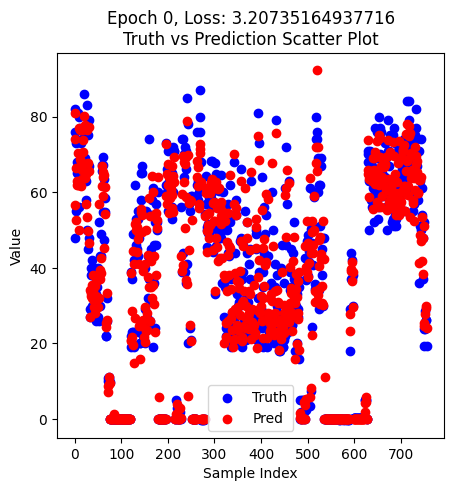

In [104]:

test_loss,test_metric=test(test_loader, model, torch.nn.MSELoss(),test_combined.gender.tolist(),0)

# Read the case study i.e. unhealthy samples from unhealthy datasets

In [105]:
folder_paths = ['/kaggle/input/unhelathy-dataset/Unhealthy Normalized']

# Initialize empty lists to store train and test DataFrames
unhealthy_frames = []


count = 0
# Step 1: Load PKL files into DataFrames
for folder_path in folder_paths:
    for filename in os.listdir(folder_path):
        if filename.endswith(".pkl") :
            file_path = os.path.join(folder_path, filename)
            df = select(pd.read_pickle(file_path))
            if(len(df)<=0):
                continue
            count+=len(df)
            # Step 2: Split each DataFrame into train and test
            train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

            # Append train and test DataFrames to lists
            unhealthy_frames.append(df)
            

In [106]:
unhealthy_data=pd.concat(unhealthy_frames)

In [107]:
X_unhealthy=unhealthy_data.drop(columns=["age",'gender','dataset','tissue_type']).astype('float')
y_unhealthy=unhealthy_data.age.astype('float')

In [108]:
unhealthy_loader=data_loader_maker(X_unhealthy,y_unhealthy,cur_edge_index,cur_edge_attr,filtered_information,batch_size=1)
        

/opt/conda/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


## see the unhealthy prediction

Epoch 0/1000: 100%|██████████| 691/691 [01:23<00:00,  8.30it/s]


Test Results: Epoch 0, Loss: 3.5636414415411943


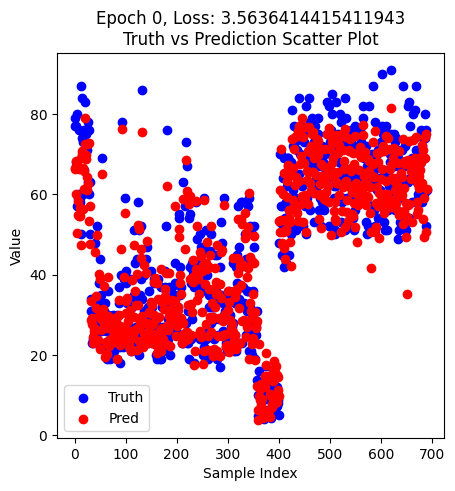

(3.5636414415411943,
   Age Group        MAE         MSE     MedAE         R2  num_sample
 0         0        NaN         NaN       NaN        NaN           0
 1      0-20   2.596454   10.695505  2.226174   0.648759          63
 2     20-45   2.495053   12.349018  1.888191   0.728547         265
 3     45-55   3.964527   25.532930  3.226828  -4.749339          70
 4     55-65   3.254287   16.879892  2.609627  -1.187725         121
 5     65-75   4.315407   37.907391  3.622719  -3.921454         110
 6     75-80   6.237641   55.040188  5.596588 -26.720571          39
 7       80+  10.802704  148.263245  9.712845 -19.639804          23)

In [109]:
test(unhealthy_loader, model, torch.nn.MSELoss(),None,0)

In [110]:
# unhealthy_data.dataset.values

In [111]:
unhealthy_graphage_pred=predict(unhealthy_loader,model)

100%|██████████| 691/691 [01:22<00:00,  8.42it/s]


In [112]:
graph_age_pred=predict(test_loader,model)

100%|██████████| 756/756 [01:29<00:00,  8.42it/s]


# Get the X and Y 's

In [113]:
def get_X_Y(desired_fold, data_list,test_data ,num_epochs=100, k=5, save_path2='best_model.pth'):
    results_list = []
    best_models = []

    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    data_array = data_list

    fold_losses = {'train': [], 'val': [], 'test': []}
    best_val_loss = float('inf')
    best_model_state_dict = None

    for fold, (train_index, val_index) in enumerate(kf.split(data_array)):
        if fold!=desired_fold:
            continue
        print(f"Starting fold {fold + 1}/{k}")
        print(train_index)
        # Split the data
        train_data = data_array.iloc[train_index,:].sample(frac=1)
        val_data = data_array.iloc[val_index,:]
        test_combined = test_data

        print('starting...')
        X_train=train_data.drop(columns=["age",'gender','dataset','tissue_type']).astype('float')
        y_train=train_data.age
        X_test=test_combined.drop(columns=["age",'gender','dataset','tissue_type']).astype('float').astype('float')
        y_test=test_combined.age
        X_val=val_data.drop(columns=["age",'gender','dataset','tissue_type']).astype('float')
        y_val=val_data.age
        return X_train,y_train,X_test,y_test,X_val,y_val
X_train,y_train,X_test,y_test,X_val,y_val=get_X_Y(2,train_combined,test_combined ,num_epochs=150, k=5, save_path2='best_model.pth')


Starting fold 3/5
[   0    1    3 ... 2947 2949 2950]
starting...


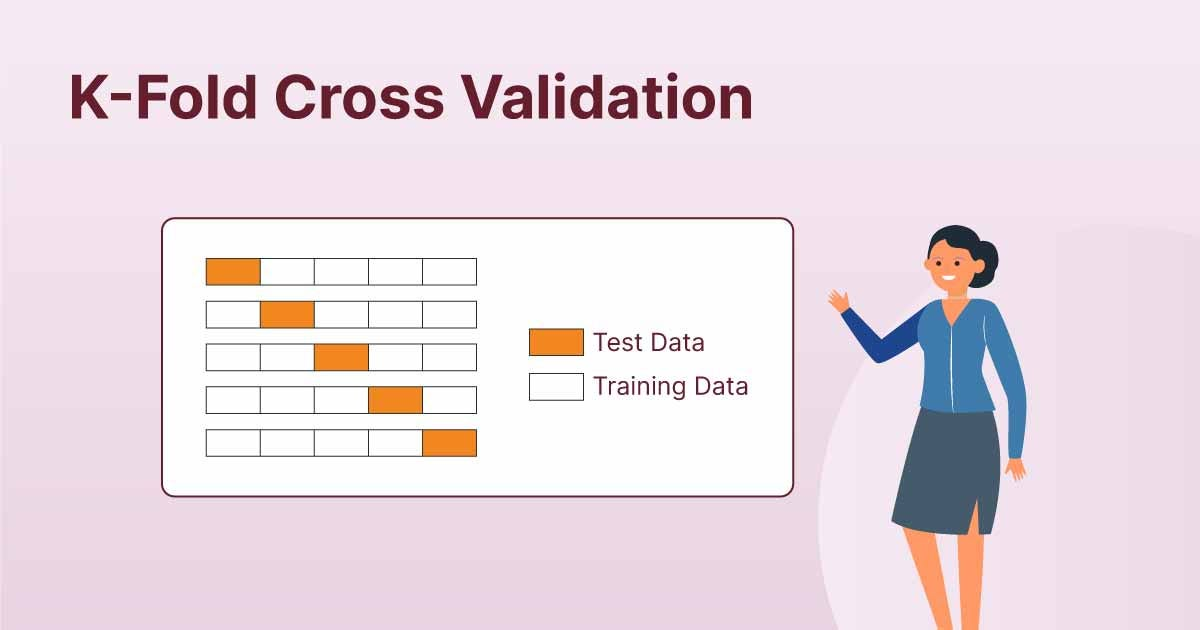

In [114]:
from IPython.display import Image

Image("/kaggle/input/graph-age-images/kfold.jpg")


# Cross validation (5 fold)
### **Pro tip**: As it takes more time to train the whole process so make 5 different account and use the desired_fold variable to run a single fold simultaneously running all folds then finally combine the results

In [115]:
# Define parameter grid and call the cross-validation function. Choose them carefully.
param_grid = {
    'lr': [.5e-3],
    'weight_decay': [ .6e-3],
    'min_lr': [  10e-12],
    'patience': [ 4],
    'factor': [.4]
}

In [116]:
I_have_checkpoint_for_train=False

In [117]:
import random
desired_fold=2
def cross_validation_training(param_grid, data_list,test_data ,num_epochs=100, k=5, save_path2='best_model.pth'):
    results_list = []
    best_models = []
    for params in ParameterGrid(param_grid):
        kf = KFold(n_splits=k, shuffle=True, random_state=42)
        data_array = data_list
        
        fold_losses = {'train': [], 'val': [], 'test': []}
        best_val_loss = float('inf')
        best_model_state_dict = None
        
        for fold, (train_index, val_index) in enumerate(kf.split(data_array)):
            if fold!=desired_fold:
                continue
            print(f"Starting fold {fold + 1}/{k}")
            print(train_index)
            # Split the data
            train_data = data_array.iloc[train_index,:].sample(frac=1)
            val_data = data_array.iloc[val_index,:]
            test_combined = test_data
            
            print('starting...')
            X_train=train_data.drop(columns=["age",'gender','dataset','tissue_type']).astype('float')
            y_train=train_data.age
            X_test=test_combined.drop(columns=["age",'gender','dataset','tissue_type']).astype('float').astype('float')
            y_test=test_combined.age
            X_val=val_data.drop(columns=["age",'gender','dataset','tissue_type']).astype('float')
            y_val=val_data.age
            print('making edges....')
            cur_edge_index,cur_edge_attr=make_graph(filtered_information,THRESHOLD_CORR,THRESHOLD_DIST,X_train,cpg2node,chromosomes)

            Organ_edge["whole_blood"]=cur_edge_index
            Organ_attr["whole_blood"]=cur_edge_attr
            print('making loaders......')
            # Create DataLoaders
            train_loader=data_loader_maker(X_train,y_train,Organ_edge["whole_blood"],Organ_attr["whole_blood"],filtered_information,batch_size=1)
            test_loader=data_loader_maker(X_test,y_test,Organ_edge["whole_blood"],Organ_attr["whole_blood"],filtered_information,batch_size=1)
            val_loader=data_loader_maker(X_val,y_val,Organ_edge["whole_blood"],Organ_attr["whole_blood"],filtered_information,batch_size=1)

            criterion = torch.nn.MSELoss()
            print('degree calculating.....')
            # Compute degree info
            max_degree, deg = compute_max_in_degree_and_histogram(train_loader)
            
            # Initialize model, optimizer, criterion, and scheduler
            model = Net(deg).to(device)
            if I_have_checkpoint_for_train:
                save_path="/kaggle/input/d/sakibahmedthesis/checkpoint/best_model_fold_2_thre_0.7 (19).pth"
                # Load the state_dict into the model
                model.load_state_dict(torch.load(save_path))
                best_val_loss ,_ = test(val_loader, model, criterion,val_data.gender.tolist(),0)
                best_model_state_dict = model.state_dict()
            optimizer = torch.optim.Adam(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])
            criterion = torch.nn.MSELoss()
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=params['factor'], patience=params['patience'], min_lr=params['min_lr'])
            print('training starting.....')
            for epoch in range(1, num_epochs + 1):
                
                loss = train(train_loader, model, optimizer, criterion, epoch)
                val_loss,val_metric = test(val_loader, model, criterion,val_data.gender.tolist(),epoch)
                test_loss,test_metric = test(test_loader, model, criterion,test_combined.gender.tolist(),epoch)
                
                
                scheduler.step(val_loss)
                
                if val_loss < best_val_loss and test_loss < 5.5:
                    best_val_loss = val_loss
                    best_model_state_dict = model.state_dict()
                    torch.save(best_model_state_dict, f'best_model_fold_{fold}_thre_{THRESHOLD_CORR}.pth')
                    val_metric.to_csv(f'val_metric_results_fold_{fold}.csv')
                    test_metric.to_csv(f'test_metric_results_fold_{fold}.csv')
                    trigger_download(f'best_model_fold_{fold}_thre_{THRESHOLD_CORR}.pth')
                    print_learning_rate(optimizer)
                elif epoch % 4 == 0:
                    torch.save(model.state_dict(), f"checkpoint_fold{fold}_thres_{THRESHOLD_CORR}.pth")
                    trigger_download(f"checkpoint_fold{fold}_thres_{THRESHOLD_CORR}.pth")
                    print_learning_rate(optimizer)
                fold_losses['train'].append(loss)
                fold_losses['val'].append(val_loss)
                fold_losses['test'].append(test_loss)
                
                print(f'Epoch:{params} {epoch:02d}, Training Loss: {loss:.4f}, Val Loss: {val_loss:.4f}, Test Loss: {test_loss:.4f}')
        
        if best_model_state_dict is not None:
            best_models.append({
                'params': params,
                'state_dict': best_model_state_dict,
                'val_loss': best_val_loss,
            })
        
        result_entry = {
            'params': params,
            'best_val_loss': best_val_loss,
            'best_test_loss': test_loss,
        }
        results_list.append(result_entry)
        
    # Plotting
    for idx, model_entry in enumerate(best_models):
        plt.plot(fold_losses['train'], label=f'Train Loss (Model {idx + 1})')
        plt.plot(fold_losses['val'], label=f'Val Loss (Model {idx + 1})')
        plt.plot(fold_losses['test'], label=f'Test Loss (Model {idx + 1})')
    
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Losses of Best Models')
    plt.show()
    
    # Save results to CSV
    results_df = pd.DataFrame(results_list)
    results_df.to_csv('hyperparameter_results.csv', index=False)




In [118]:
# Assuming data_list is prepared as shown in previous examples
if I_want_to_train:
    cross_validation_training(param_grid, train_combined,test_combined ,num_epochs=150, k=5, save_path2='best_model.pth')


In [119]:
!ls

asd.txt  ytest.npy


In [120]:
# model=Net().to(device)
# model.load_state_dict(best_model_state_dict)

In [121]:
# test(test_loader,model)

# Explanation

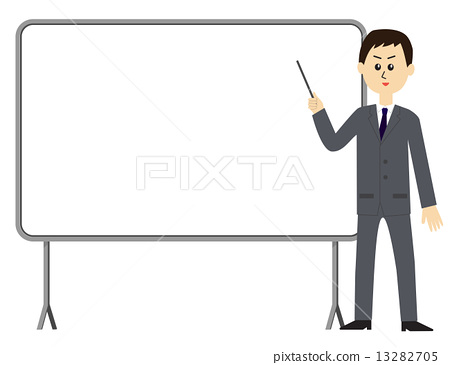

In [122]:
from IPython.display import Image

Image("/kaggle/input/graph-age-images/explanation.jpg")


# Decalre Explanation

In [123]:
from torch_geometric.explain import Explainer, GNNExplainer,GraphMaskExplainer,PGExplainer
explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=120),
    explanation_type='phenomenon',
    node_mask_type='common_attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='regression',
        task_level='graph',
        return_type='raw',
    ),

)
explainer2 = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=120),
    explanation_type='phenomenon',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='regression',
        task_level='graph',
        return_type='raw',
    ),

)
explainer3 = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=120),
    explanation_type='phenomenon',
    node_mask_type='object',
    edge_mask_type='object',
    model_config=dict(
        mode='regression',
        task_level='graph',
        return_type='raw',
    ),

)

# initialize or load from checkpoint 
## for loading you need to create the explanation-checkpoint dataset and open it in another tab and go to the last to update then update it here as well.
### The reason I did not give my checkpoint because you won't be able to update it better if you create one

In [ ]:
if input("load???")=="y":
    age_group_weights_edge = np.load('/kaggle/input/explanation-checkpoint/kaggle/working/age_group_sum_edge.npy')
    age_group_weights_node=np.load('/kaggle/input/explanation-checkpoint/kaggle/working/age_group_sum_node.npy')
    length=np.load('/kaggle/input/explanation-checkpoint/kaggle/working/length_of_each_age_grp.npy')
    node_importance=list(np.load('/kaggle/input/explanation-checkpoint/kaggle/working/node_importance.npy'))
    node_attr_importance=list(np.load('/kaggle/input/explanation-checkpoint/kaggle/working/node_attr_importance.npy'))
    done = int(np.sum(length))
else:
    done=0
    age_group_weights_edge=np.zeros(shape=(8,cur_edge_index.shape[1]))
    age_group_weights_node=np.zeros(shape=(8,len(X_test.columns)))
    length=np.zeros(shape=8)
    node_importance=[]
    node_attr_importance=[]

# This changes the test loader excluding the already done ones

In [ ]:

test_loader=data_loader_maker(X_test.iloc[done:,:],y_test[done:],Organ_edge["whole_blood"],Organ_attr["whole_blood"],filtered_information,batch_size=1)


# We compile all the explanations

In [ ]:
def compile_result(explainer,explainer2,path):
    l = len(test_loader)
    node_mask=[]
    edge_mask=[]
    
    cnt=0
    for data in tqdm(test_loader, total=len(test_loader)):
      data.to(device)
      explanation2=explainer2(x=data.x,edge_index=data.edge_index,edge_attr=data.edge_attr,batch=data.batch_size,target=data.y)
      explanation=explainer(x=data.x,edge_index=data.edge_index,edge_attr=data.edge_attr,batch=data.batch_size,target=data.y)
#       node_mask.append(explanation.node_mask.cpu().detach().flatten().tolist())
      age_group_weights_edge[age_group(data.y.cpu().item())]+=explanation.edge_mask.cpu().detach().flatten().numpy()
      age_group_weights_node[age_group(data.y.cpu().item())]+=explanation.node_mask.cpu().detach().flatten().numpy()
      node_importance.append(explanation.node_mask.cpu().detach().flatten().numpy())
      node_attr_importance.append(explanation2.node_mask.cpu().detach().flatten().numpy())
      length[age_group(data.y.cpu().item())]+=1
      # Saving to CSV
      if cnt%10==0 or cnt>=(len(test_loader)-1):
        # Save the array to a file
        np.save(f'age_group_sum_edge.npy', age_group_weights_edge)
        np.save(f'age_group_sum_node.npy', age_group_weights_node)
        np.save('length_of_each_age_grp.npy', length)
        np.save('node_importance.npy', np.array(node_importance))
        np.save('node_attr_importance.npy', np.array(node_attr_importance))
        
        # Create a zip file containing all the saved numpy files
        import zipfile
        with zipfile.ZipFile('/kaggle/working/data.zip', 'w') as zipf:
            zipf.write('age_group_sum_edge.npy')
            zipf.write('age_group_sum_node.npy')
            zipf.write('length_of_each_age_grp.npy')
            zipf.write('node_importance.npy')
            zipf.write('node_attr_importance.npy')

        # Display a download link using FileLink
        display(FileLink('data.zip'))
      cnt+=1

In [ ]:
# compile_result(explainer3,explainer,'object_explanation')

In [ ]:
np.save('edge_index.npy',cur_edge_index)
np.save('edge_attr.npy',cur_edge_attr)

# Comparison between Altum Age and Graph Age
### Be care ful using Graph Age after running AltumAge because of pytorch and tensorflow conflict

# Altum Age code

In [125]:
!pip -q install wurlitzer neural_structured_learning tensorflow_docs keras tensorflow

In [126]:
import neural_structured_learning as nsl

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
import tensorflow as tf
# from keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras import regularizers
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, InputLayer, ActivityRegularization, GaussianDropout, GaussianNoise, Embedding, Bidirectional, Input, LSTM, GRU, multiply, Lambda, PReLU, SimpleRNN, Dense, Activation, BatchNormalization, Conv2D, Conv1D, Flatten, LeakyReLU, Dropout, MaxPooling2D, MaxPooling1D, Reshape

2024-07-04 07:31:36.109379: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-04 07:31:36.109488: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-04 07:31:36.239855: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [127]:
def AltumAge(X_train,y_train,X_val,y_val):
  noise = 0.1
  np.random.seed(42)
  tf.random.set_seed(42)
  initializer = tf.keras.initializers.LecunNormal(seed=1)
  #neural network architecture
  coeff = 0.05 * np.sqrt(2.0 * np.log(X_train.shape[1]) / X_train.shape[0])
  nn_model = Sequential([
      Input(shape=(20318,), name = 'feature'),
      BatchNormalization(),
      GaussianDropout(noise),
      ActivityRegularization(0, coeff*10),
      Dense(32, kernel_initializer = initializer, kernel_regularizer=tf.keras.regularizers.l1_l2(0, coeff*2)),
      Activation('selu'),
      BatchNormalization(),
      GaussianDropout(noise),
      ActivityRegularization(0, 0),
      Dense(32, kernel_initializer = initializer, kernel_regularizer=tf.keras.regularizers.l1_l2(0, coeff*2)),
      Activation('selu'),
      BatchNormalization(),
      GaussianDropout(noise),
      ActivityRegularization(0, 0),
      Dense(32, kernel_initializer = initializer, kernel_regularizer=tf.keras.regularizers.l1_l2(0, coeff*2)),
      Activation('selu'),
      BatchNormalization(),
      GaussianDropout(noise),
      ActivityRegularization(0, 0),
      Dense(32, kernel_initializer = initializer, kernel_regularizer=tf.keras.regularizers.l1_l2(0, coeff*2)),
      Activation('selu'),
      BatchNormalization(),
      GaussianDropout(noise),
      ActivityRegularization(0, 0),
      Dense(32, kernel_initializer = initializer, kernel_regularizer=tf.keras.regularizers.l1_l2(0, coeff*2)),
      Activation('selu'),
      BatchNormalization(),
      Dense(1)
  ])
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

  # Compile, train, and evaluate.
  nn_model.compile(optimizer=optimizer,
                    loss='mse',
                    metrics=['mae'])
  reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2,
                                patience=30, min_lr=0.00001)
  checkpoint_filepath = '/tmp/checkpoint'
  model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_best_only=True)
  nn_model.fit(X_train.to_numpy(),
                y_train.to_numpy().astype('float'),
                batch_size=256,
                epochs=300,
                verbose=0,
                callbacks=[model_checkpoint_callback, reduce_lr],
                validation_data=(X_val.to_numpy(), y_val.to_numpy().astype('float')))
  return nn_model

In [128]:

altumage_model=AltumAge(X_train,y_train,X_val,y_val)

I0000 00:00:1720078310.345717     173 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [129]:
def Altum_pred(model,X_val):
  return model.predict(X_val).flatten()

In [130]:
def evaluate_metrics(gender, predictions, ground_truth):
    df = pd.DataFrame({'gender': gender, 'predictions': predictions, 'ground_truth': ground_truth})
    df['age_group'] = df['ground_truth'].apply(age_group)
    age_group_name=['0','0-20','20-45','45-55','55-65','65-75','75-85','80+']
    results = []
    for ag in range(len(age_group_name)):
      for gen in df['gender'].unique():
            subset = df[(df['gender'] == gen) & (df['age_group'] == ag)]

            if subset.empty:
                results.append({
                    'Age Group': ag,
                    'Age Group_name': age_group_name[ag],
                    'Gender': gen,
                    'MAE': 0,
                    'MSE': 0,
                    # 'R2': r2,
                    'MedAE': 0,
                    'Num Samples': 0
                })
                continue

            y_true = subset['ground_truth']
            y_pred = subset['predictions']

            mae = mean_absolute_error(y_true, y_pred)
            mse = mean_squared_error(y_true, y_pred)
            r2 = r2_score(y_true, y_pred)
            medae = median_absolute_error(y_true, y_pred)
            num_samples = len(subset)

            results.append({
                'Age Group': ag,
                'Age Group_name': age_group_name[ag],
                'Gender': gen,
                'MAE': mae,
                'MSE': mse,
                # 'R2': r2,
                'MedAE': medae,
                'Num Samples': num_samples
            })

    return pd.DataFrame(results).sort_values(by=['Age Group'])[['MAE','MSE','MedAE','Num Samples']]

In [148]:
import pickle

# Define the file path
file_path = '/kaggle/input/altumage-weights-from-5-fold-cross-validation/altum_age_weights'

# Load the pickle file
with open(file_path, 'rb') as file:
    weights = pickle.load(file)




# Just see the best version

In [156]:
best_altum_age_model=None
best_error=float('inf')
altum_age_weights=[]
altumage_model.set_weights(weight)
for weight in weights:
    X_train,y_train,X_test,y_test,X_val,y_val=get_X_Y(i, train_combined,test_combined ,num_epochs=100, k=5)
#     altumage_model=AltumAge(X_train,y_train,X_val,y_val)
    altumage_model.set_weights(weight)
    altum_age_pred=Altum_pred(altumage_model,X_val)
    cur_error=np.mean(abs(altum_age_pred-y_val))
    
    if best_error>cur_error:
        best_altum_age_model=altumage_model
        best_error=cur_error
    
    
        

Starting fold 5/5
[   0    2    3 ... 2948 2949 2950]
starting...
19/19 [==============================] - 0s 4ms/step
Starting fold 5/5
[   0    2    3 ... 2948 2949 2950]
starting...
19/19 [==============================] - 0s 4ms/step
Starting fold 5/5
[   0    2    3 ... 2948 2949 2950]
starting...
19/19 [==============================] - 0s 3ms/step
Starting fold 5/5
[   0    2    3 ... 2948 2949 2950]
starting...
19/19 [==============================] - 0s 4ms/step
Starting fold 5/5
[   0    2    3 ... 2948 2949 2950]
starting...
19/19 [==============================] - 0s 3ms/step


In [159]:
altum_age_pred=Altum_pred(best_altum_age_model,X_test)
altum_age_best_error=np.mean(abs(altum_age_pred-y_test))
print(altum_age_best_error)

24/24 [==============================] - 0s 4ms/step
3.2960190767657487


# Train altum age to get the result

In [141]:
best_altum_age_model=None
best_error=float('inf')
cv_error=0
altum_age_weights=[]
for i in range(5):
    X_train,y_train,X_test,y_test,X_val,y_val=get_X_Y(i, train_combined,test_combined ,num_epochs=100, k=5)
    altumage_model=AltumAge(X_train,y_train,X_val,y_val)
    altum_age_pred=Altum_pred(altumage_model,X_val)
    cur_error=np.mean(abs(altum_age_pred-y_val))
    altum_age_weights.append(altumage_model.get_weights())
#     evaluate_metrics(gender, predictions, ground_truth)
    if best_error>cur_error:
        best_altum_age_model=altumage_model
        best_error=cur_error
    
    print(cur_error)
    cv_error+=cur_error
print(cv_error)
        

Starting fold 1/5
[   0    1    2 ... 2945 2947 2948]
starting...
19/19 [==============================] - 0s 4ms/step
3.194108313988242
Starting fold 2/5
[   1    2    3 ... 2948 2949 2950]
starting...
19/19 [==============================] - 0s 4ms/step
3.2088794399438925
Starting fold 3/5
[   0    1    3 ... 2947 2949 2950]
starting...
19/19 [==============================] - 0s 4ms/step
3.442221420081965
Starting fold 4/5
[   0    1    2 ... 2948 2949 2950]
starting...
19/19 [==============================] - 0s 4ms/step
3.484815182846703
Starting fold 5/5
[   0    2    3 ... 2948 2949 2950]
starting...
19/19 [==============================] - 0s 4ms/step
3.321837610511022
16.651861967371826


In [161]:
cv_error/5

0.0

In [157]:
altum_age_pred=Altum_pred(best_altum_age_model,X_test)
altum_age_best_error=np.mean(abs(altum_age_pred-y_test))
print(altum_age_best_error)

24/24 [==============================] - 0s 4ms/step
3.2960190767657487


In [144]:
weights=altum_age_weights

In [ ]:
altum_metric=evaluate_metrics(test_combined.gender.tolist(), altum_age_pred, y_test)

In [ ]:
altum_metric

In [ ]:
test_metric["Unnamed: 0"]=test_metric['Age Group']+test_metric['Gender']

In [ ]:
cur=test_metric.rename(columns={'MAE':'GraphAge MAE','MSE':'GRAPH AGE MSE'}).join(altum_metric.rename(columns={'MAE':'AltumAge MAE','MSE':'AltumAge MSE','MedAE':'asd','Num Samples':'dsa'}))

In [ ]:
graph_mse=0
tot_sample=0
for mse , num in zip(test_metric.MSE,test_metric.num_sample):
        graph_mse+=mse*num
        tot_sample+=num
graph_mse_avg=graph_mse/tot_sample

In [ ]:
# altum_metric

In [ ]:

altum_mse=0
tot_sample=0
for mse , num in zip(altum_metric.MSE,altum_metric['Num Samples']):
        altum_mse+=mse*num
        tot_sample+=num
altum_mse_avg=altum_mse/tot_sample

In [ ]:
# prompt: plot cur with columns containing MAE in them use contains or regex use 'Unnamed: 0 as ticks in x axis

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 6))

# Filter columns that contain "MAE" in their name
mae_cols = [col for col in cur.columns if "MSE" in col]
print(mae_cols)
# Plot the columns
cur[mae_cols].plot(kind="bar", ax=ax)

# Set ticks and labels
ax.set_xticks(range(len(cur)))
ax.set_xticklabels(cur["Unnamed: 0"], rotation=90)

# Add title and legend
ax.set_title(f"MSE Comparison for different age and gender(M,F) group\nGraphAge MSE: {graph_mse_avg}\n AltumAge MSE: {altum_mse_avg}", size=14)
ax.legend(loc="upper right")

# Show the plot
plt.savefig('altumage_graph_age_independent_set_comparison.jpg')


In [ ]:
cnt=-1
for data in tqdm(test_loader, total=len(test_loader)):
    data.to(device)
    cnt+=1
    if cnt<=1:
        continue
      
    explanation=explainer(x=data.x,edge_index=data.edge_index,edge_attr=data.edge_attr,batch=data.batch_size,target=data.y)
    break

In [ ]:
print('ok')

# Gene Specific Analysis

In [ ]:
node2gene={}
for i,g in enumerate(filtered_information.Symbol.tolist()):
  node2gene[i]=g


# zip

In [ ]:
np.save('edge_index.npy',cur_edge_index)
np.save('edge_attr.npy',cur_edge_attr)

In [ ]:
!ls
!zip -r file.zip "/kaggle/working"

# Get all results with this link

In [ ]:

from IPython.display import FileLink
FileLink(r'file.zip')